In [5]:
import akshare as ak
print("AkShare version:", ak.__version__)
import os, time, math, random
import pandas as pd
import requests
from urllib3.util.retry import Retry
from requests.adapters import HTTPAdapter
import numpy as np
import matplotlib.pyplot as plt

AkShare version: 1.17.61


In [6]:
# 只抓取：上证A（fs = m:0 t:6）
# 行为：
# 1) 先探测 total（若失败也继续尽量下载）
# 2) 分页拉取，每页成功就立即写入 CSV（可续传）
# 3) 一旦出现接口限制/网络错误，立即保存已下数据 -> sleep(15s) -> 继续剩余页
# 4) 多轮抓取直到拿全或达到轮次上限；最终 CSV 去重合并

import os, time, math, random
import pandas as pd
import requests
from urllib3.util.retry import Retry
from requests.adapters import HTTPAdapter

# -------- 可调参数 --------
CSV_PATH         = "/Users/zouxd/Documents/GitHub/MyTools/ak-tool-sh_a_snapshot.csv"   # 最终合并保存位置
PAGE_SIZE        = 200                   # 每页条数（100~500均可；越大越容易被限速，200较稳）
WAIT_SECONDS     = 15                    # 被限/出错后，等待再继续的秒数
ROUND_LIMIT      = 6                     # 最多尝试的轮数（每轮失败会等待后重试）
PER_PAGE_RETRY   = 3                     # 单页重试次数上限

# Eastmoney push2 备用域名（随机尝试，提升命中率）
HOSTS = [
    "https://push2.eastmoney.com/api/qt/clist/get",
    "https://82.push2.eastmoney.com/api/qt/clist/get",
    "https://32.push2.eastmoney.com/api/qt/clist/get",
]

FS_SH_A   = "m:0 t:6"         # 上证A
FIELDS    = "f12,f14"         # 只要 代码(f12) 和 名称(f14)，减小负载
COMMON_QS = {
    "po": "1",
    "np": "1",
    "ut": "bd1d9ddb04089700cf9c27f6f7426281",
    "fltt": "2",
    "invt": "2",
    "fid": "f12",
    "fs": FS_SH_A,
    "fields": FIELDS,
}

def make_session():
    s = requests.Session()
    retry = Retry(
        total=5, connect=5, read=5,
        backoff_factor=0.6,
        status_forcelist=[429, 500, 502, 503, 504],
        allowed_methods=["GET"],
        raise_on_status=False,
    )
    s.mount("https://", HTTPAdapter(max_retries=retry))
    s.headers.update({
        "User-Agent": "Mozilla/5.0",
        "Referer": "https://quote.eastmoney.com/",
        "Accept": "application/json, text/plain, */*",
    })
    return s

def read_existing(csv_path: str) -> pd.DataFrame:
    if os.path.exists(csv_path):
        try:
            df = pd.read_csv(csv_path, dtype={"代码": str, "名称": str})
            # 统一列名
            if "代码" not in df.columns and "code" in df.columns:
                df = df.rename(columns={"code": "代码"})
            if "名称" not in df.columns and "name" in df.columns:
                df = df.rename(columns={"name": "名称"})
            df["代码"] = df["代码"].astype(str).str.strip()
            df["名称"] = df["名称"].astype(str).str.strip()
            df = df[["代码", "名称"]].drop_duplicates(subset=["代码"])
            return df
        except Exception:
            pass
    return pd.DataFrame(columns=["代码", "名称"])

def save_merged(csv_path: str, df_existing: pd.DataFrame, df_new: pd.DataFrame) -> pd.DataFrame:
    if not df_new.empty:
        merged = pd.concat([df_existing, df_new], ignore_index=True)
        merged = merged.drop_duplicates(subset=["代码"]).sort_values("代码")
    else:
        merged = df_existing.drop_duplicates(subset=["代码"]).sort_values("代码")
    merged.to_csv(csv_path, index=False)
    return merged

def get_total(session: requests.Session) -> int | None:
    """探测 total；失败时返回 None，不中断流程。"""
    params = dict(COMMON_QS)
    params.update({"pn": "1", "pz": "1"})
    for base in random.sample(HOSTS, k=len(HOSTS)):
        try:
            r = session.get(base, params=params, timeout=15)
            if r.status_code == 429:
                # 限流：返回 None，让上层走分页补抓逻辑
                return None
            r.raise_for_status()
            j = r.json()
            total = (j or {}).get("data", {}).get("total")
            if isinstance(total, int) and total > 0:
                return total
        except Exception:
            continue
    return None

def fetch_page(session: requests.Session, pn: int, pz: int) -> pd.DataFrame:
    """抓取指定页，返回 DataFrame(['代码','名称'])；失败抛异常。"""
    params = dict(COMMON_QS)
    params.update({"pn": str(pn), "pz": str(pz)})
    last_err = None
    for _ in range(PER_PAGE_RETRY):
        for base in random.sample(HOSTS, k=len(HOSTS)):
            try:
                r = session.get(base, params=params, timeout=15)
                if r.status_code == 429:
                    # 限速：抛出特定异常给上层处理
                    raise requests.HTTPError("429 Too Many Requests")
                r.raise_for_status()
                j = r.json()
                diff = (j or {}).get("data", {}).get("diff", []) or []
                rows = []
                for it in diff:
                    code = str(it.get("f12", "")).strip()
                    name = str(it.get("f14", "")).strip()
                    if code:
                        rows.append({"代码": code, "名称": name})
                return pd.DataFrame(rows, columns=["代码", "名称"])
            except Exception as e:
                last_err = e
                continue
    raise RuntimeError(f"fetch_page 失败：pn={pn}, pz={pz}, err={repr(last_err)}")

# ---------- 主流程 ----------
sess = make_session()
existing = read_existing(CSV_PATH)
print(f"已存在本地数据：{len(existing)} 条（{CSV_PATH}）")

total = get_total(sess)
if total:
    print(f"服务器报告总数：{total}（上证A）")
else:
    print("无法可靠获得 total，改为尽可能分页抓取（离线兜底继续）。")

# 若知道total就算总页数；否则设一个“乐观上限”，按常见规模 4000 给页数上限（会提前收敛）
pz = PAGE_SIZE
max_pages = math.ceil((total or 4000) / pz)

round_idx = 1
while round_idx <= ROUND_LIMIT:
    print(f"\n=== 第 {round_idx} 轮抓取开始 ===")
    failed = False
    new_rows_total = 0

    # 遍历页码
    for pn in range(1, max_pages + 1):
        # 如果已有 total 且已经拿够了，就提前结束
        if total and len(existing) >= total:
            print("已达到/超过总数，提前结束。")
            failed = False
            break

        # 小优化：如果 total 未知，当出现连续空页时提前结束
        try:
            df_page = fetch_page(sess, pn, pz)
        except Exception as e:
            print(f"第 {pn} 页失败：{e}")
            failed = True
            break

        if df_page.empty:
            print(f"第 {pn} 页为空。")
            # 如果连续空页，可能已经到末尾或被限流，视为本轮结束
            # 这里直接结束本轮，进入等待
            failed = True
            break

        # 合并并落盘（去重）
        before = len(existing)
        existing = save_merged(CSV_PATH, existing, df_page)
        added = len(existing) - before
        new_rows_total += max(0, added)

        print(f"第 {pn} 页：拿到 {len(df_page)} 条，新增加 {added} 条，累计 {len(existing)} 条。")

        # 若 total 未知，但 df_page 数量 < pz，可能到尾页，尝试提前结束一轮
        if not total and len(df_page) < pz:
            print("疑似尾页，结束本轮。")
            failed = False
            break

    # 轮次结束条件判断
    if not failed:
        # 若 total 已知且够了；或 total 未知但这一轮没有失败，认为完成
        if total and len(existing) >= total:
            print(f"\n✅ 完成：共 {len(existing)} 条（与 total {total} 基本一致）。已写入 {CSV_PATH}")
            break
        elif not total:
            # total 未知：如果这一轮没有失败，认为到达末尾
            print(f"\n✅ 完成（total 未知）：共 {len(existing)} 条。已写入 {CSV_PATH}")
            break

    # 如果失败了，等待再继续
    print(f"\n⚠️ 本轮未完成，已保存 {len(existing)} 条。等待 {WAIT_SECONDS}s 后继续剩余下载……")
    time.sleep(WAIT_SECONDS)
    round_idx += 1

# 最终落盘去重一次
existing = existing.drop_duplicates(subset=["代码"]).sort_values("代码")
existing.to_csv(CSV_PATH, index=False)
print(f"\n最终结果：{len(existing)} 条，上证A 代码/名称已保存到：{os.path.abspath(CSV_PATH)}")


已存在本地数据：100 条（/Users/zouxd/Documents/GitHub/MyTools/ak-tool-sh_a_snapshot.csv）
服务器报告总数：1626（上证A）

=== 第 1 轮抓取开始 ===
第 1 页：拿到 100 条，新增加 0 条，累计 100 条。
第 2 页：拿到 100 条，新增加 100 条，累计 200 条。
第 3 页：拿到 100 条，新增加 100 条，累计 300 条。
第 4 页：拿到 100 条，新增加 100 条，累计 400 条。
第 5 页：拿到 100 条，新增加 100 条，累计 500 条。
第 6 页：拿到 100 条，新增加 100 条，累计 600 条。
第 7 页：拿到 100 条，新增加 100 条，累计 700 条。
第 8 页：拿到 100 条，新增加 100 条，累计 800 条。
第 9 页：拿到 100 条，新增加 100 条，累计 900 条。

⚠️ 本轮未完成，已保存 900 条。等待 15s 后继续剩余下载……


KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def find_symbol_by_name(name: str) -> str:
    code_map = ak.stock_info_a_code_name()
    # 兼容不同列名
    if {"code","name"}.issubset(code_map.columns):
        code_col, name_col = "code", "name"
    elif {"证券代码","证券简称"}.issubset(code_map.columns):
        code_col, name_col = "证券代码", "证券简称"
    else:
        raise RuntimeError(f"无法识别代码/名称列: {list(code_map.columns)}")
    hit = code_map.loc[code_map[name_col] == name]
    if hit.empty:
        hit = code_map.loc[code_map[name_col].str.contains(name, na=False)]
    if hit.empty:
        raise RuntimeError(f"未找到股票：{name}")
    return str(hit.iloc[0][code_col]).strip()

def _standardize_cols(df: pd.DataFrame) -> pd.DataFrame:
    # 统一中英列名
    colmap = {
        "日期":"date","date":"date",
        "开盘":"open","open":"open",
        "最高":"high","high":"high",
        "最低":"low","low":"low",
        "收盘":"close","close":"close",
        "成交量":"volume","volume":"volume",
        "成交额":"amount","amount":"amount",
    }
    rename = {c:colmap.get(c,c) for c in df.columns}
    df = df.rename(columns=rename)
    if "date" not in df.columns or "close" not in df.columns:
        raise RuntimeError(f"缺少必要列: {list(df.columns)}")
    # 类型与索引
    df["date"] = pd.to_datetime(df["date"])
    for k in ["open","high","low","close","volume","amount"]:
        if k in df.columns:
            df[k] = pd.to_numeric(df[k], errors="coerce")
    df = df.sort_values("date").set_index("date")
    return df

def get_hist_clean(symbol: str, start="2018-01-01", end="2025-12-31", prefer="hfq") -> tuple[pd.DataFrame,str]:
    # 依次尝试 hfq -> qfq -> 不复权
    tried = []
    for adj in list(dict.fromkeys([prefer, "qfq", ""])):  # 去重保序
        tried.append(adj or "none")
        df = ak.stock_zh_a_hist(symbol=symbol, period="daily", start_date=start.replace("-",""),
                                end_date=end.replace("-",""), adjust=adj)
        df = _standardize_cols(df)
        # 体检：剔除负价、全零
        bad_neg = ((df[["open","high","low","close"]] < 0).any(axis=1)).sum()
        if bad_neg > 0:
            # 该复权口径存在异常，尝试下一个
            continue
        all_zero = (df["close"] == 0).sum()
        if all_zero > 0:
            # 零价异常也视为不可用
            continue
        return df, (adj or "none")
    raise RuntimeError(f"所有口径均异常或不可用，已尝试：{tried}")

# ===== 示例：拿“兴瑞科技”，并画日/周/月同图 =====
name = "兴瑞科技"
symbol = find_symbol_by_name(name)
df_daily, used_adj = get_hist_clean(symbol, start="2025-07-31", end="2025-09-30", prefer="hfq")
close_d = df_daily["close"].dropna()
close_w = close_d.resample("W-FRI").last().dropna()
close_m = close_d.resample("M").last().dropna()

print(f"{name}({symbol}) 获取成功，复权口径：{used_adj}，样本数：{len(close_d)}")

plt.figure(figsize=(12,6))
plt.plot(close_d.index, close_d.values, label="日线收盘")
plt.plot(close_w.index, close_w.values, label="周线收盘")
plt.plot(close_m.index, close_m.values, label="月线收盘")
plt.title(f"{name}（{symbol}）日/周/月 收盘价（口径：{used_adj}）")
plt.xlabel("日期"); plt.ylabel("价格（元）")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


In [ ]:
stock_szse_summary_df = ak.stock_szse_summary(date="20250930")
print(stock_szse_summary_df)

In [16]:

stock_zh_a_hist_df = ak.stock_zh_a_hist(symbol="000001", period="daily", start_date="20250731", end_date='20250930', adjust="")
print(stock_zh_a_hist_df)

            日期    股票代码     开盘     收盘     最高     最低      成交量           成交额  \
0   2025-07-31  000001  12.51  12.23  12.55  12.22  1690081  2.079631e+09   
1   2025-08-01  000001  12.24  12.28  12.33  12.15  1012187  1.240239e+09   
2   2025-08-04  000001  12.24  12.30  12.38  12.21  1032690  1.271376e+09   
3   2025-08-05  000001  12.30  12.47  12.50  12.28  1132078  1.405152e+09   
4   2025-08-06  000001  12.47  12.46  12.52  12.40   690448  8.596847e+08   
5   2025-08-07  000001  12.44  12.47  12.53  12.39   722053  9.007600e+08   
6   2025-08-08  000001  12.48  12.40  12.53  12.39   829796  1.032587e+09   
7   2025-08-11  000001  12.40  12.30  12.42  12.27   934353  1.150305e+09   
8   2025-08-12  000001  12.30  12.33  12.40  12.30   680056  8.396356e+08   
9   2025-08-13  000001  12.37  12.26  12.40  12.23  1119813  1.376778e+09   
10  2025-08-14  000001  12.27  12.20  12.34  12.19  1241041  1.523448e+09   
11  2025-08-15  000001  12.23  12.08  12.23  11.94  1948503  2.344073e+09   

In [10]:


# ================================================================
import os, re, math, time
from datetime import datetime, timedelta
from calendar import monthrange
import numpy as np
import matplotlib.pyplot as plt

# ---------- 常用小工具 ----------

def normalize_ymd(s: str) -> str:
    """
    将形如 YYYYMMDD 的字符串规整为**存在的日期**。
    若日>当月天数，则取当月最后一天；若格式异常则抛错。
    """
    s = re.sub(r"\D", "", s)
    if len(s) != 8:
        raise ValueError(f"非法日期：{s}")
    y, m, d = int(s[:4]), int(s[4:6]), int(s[6:])
    if not (1 <= m <= 12):
        raise ValueError(f"非法月份：{s}")
    dim = monthrange(y, m)[1]
    d = min(max(d, 1), dim)
    return f"{y:04d}{m:02d}{d:02d}"

def ensure_dir(p: str):
    if not os.path.exists(p):
        os.makedirs(p, exist_ok=True)

def std_cols(df: pd.DataFrame) -> pd.DataFrame:
    """把 AkShare 的中英列名统一成英文，并设置 datetime 索引。"""
    colmap = {
        "日期":"date","date":"date",
        "开盘":"open","open":"open",
        "最高":"high","high":"high",
        "最低":"low","low":"low",
        "收盘":"close","close":"close",
        "成交量":"volume","volume":"volume",
        "成交额":"amount","amount":"amount",
    }
    df = df.rename(columns={c: colmap.get(c, c) for c in df.columns})
    if "date" not in df.columns or "close" not in df.columns:
        raise RuntimeError(f"缺少必要列：{list(df.columns)}")
    df["date"] = pd.to_datetime(df["date"])
    for k in ["open","high","low","close","volume","amount"]:
        if k in df.columns:
            df[k] = pd.to_numeric(df[k], errors="coerce")
    df = df.sort_values("date").drop_duplicates(subset=["date"]).set_index("date")
    return df

def load_a_share_codes() -> pd.DataFrame:
    """
    读取 A 股代码表，返回 DataFrame(['code','name'])。
    过滤出 6 位数字代码（主板/创业/科创），不含北交所的 8 开头等。
    """
    tab = ak.stock_info_a_code_name()  # 含 A 股主板/创业/科创
    if {"code","name"}.issubset(tab.columns):
        df = tab[["code","name"]].copy()
    elif {"证券代码","证券简称"}.issubset(tab.columns):
        df = tab.rename(columns={"证券代码":"code","证券简称":"name"})[["code","name"]].copy()
    else:
        raise RuntimeError(f"无法识别代码/名称列：{list(tab.columns)}")
    df["code"] = df["code"].astype(str).str.strip()
    df = df[df["code"].str.fullmatch(r"\d{6}")]
    df = df.drop_duplicates(subset=["code"]).reset_index(drop=True)
    return df

def fetch_hist(symbol: str, start_ymd: str, end_ymd: str, adjust: str = "") -> pd.DataFrame:
    """
    先走 AkShare；遇到网络中断/限流类错误（如 RemoteDisconnected/Connection/Timeout），
    自动兜底走 push2his 直连；其他错误原样抛出。
    """
    try:
        raw = ak.stock_zh_a_hist(symbol=symbol, period="daily",
                                 start_date=start_ymd, end_date=end_ymd, adjust=adjust)
        return std_cols(raw)
    except Exception as e:
        msg = str(e)
        transient = ("Remote end closed" in msg) or ("Connection" in msg) or ("Timeout" in msg)
        if transient:
            # 兜底直连（依旧失败会抛 RuntimeError）
            return fetch_hist_em_direct(symbol, start_ymd, end_ymd, adjust)
        # 非网络类错误，直接抛出让上层处理（比如代码无效等）
        raise

def csv_path(symbol: str) -> str:
    return os.path.join(DATA_DIR, f"{symbol}.csv")

# ---------- 模块一：分批下载所有 A 股到单独 CSV ----------

def batch_download_all(start_raw: str, end_raw: str, adjust: str = ADJUST,
                       start_at: int = 1, resume_from_symbol: str | None = None,
                       per_item_sleep: tuple[float,float] = (0.3, 0.9),
                       cooldown_every: int = 50,
                       cooldown_seconds: tuple[float,float] | float = (55, 75)):
    """
    分批下载所有 A 股历史到 CSV，支持续跑 + 限速：
    - start_at：从代码表的第几个开始（1-based）
    - resume_from_symbol：从指定代码的“下一个”开始
    - per_item_sleep：(low, high) 每抓一只前随机停顿秒数区间；None/0 关闭
    - cooldown_every：每抓满 N 只后强制冷却；<=0 关闭
    - cooldown_seconds：冷却时长，给 (low, high) 会随机；给单个数则固定时长
    """
    import random, time

    start = normalize_ymd(start_raw)
    end   = normalize_ymd(end_raw)
    ensure_dir(DATA_DIR)

    codes = load_a_share_codes()   # DataFrame(['code','name'])
    total = len(codes)

    # 若按代码名续跑，定位到该代码的“下一个”
    if resume_from_symbol:
        pos = codes.index[codes["code"] == str(resume_from_symbol).strip()]
        if len(pos):
            start_at = int(pos[0]) + 2
        else:
            print(f"提示：代码 {resume_from_symbol} 不在列表中，改用 start_at={start_at}")

    start_at = max(1, min(start_at, total))
    iter_df = codes.iloc[start_at-1:]
    ok, fail = 0, 0
    hits = 0  # 实际“发起抓取”的只数（已存在的 CSV 不计入）

    print(f"计划下载：{total} 只；从第 {start_at}/{total} 开始；区间 {start}~{end}；口径：{adjust or 'none'}")

    for j, row in enumerate(iter_df.itertuples(index=False), start=start_at):
        sym, name = row.code, row.name
        out = csv_path(sym)

        # 已存在则跳过（不算 hits）
        if os.path.exists(out):
            print(f"[{j}/{total}] 跳过 {sym} {name}（已存在）")
            continue

        # —— 每只之前的随机停顿 —— 
        if per_item_sleep and isinstance(per_item_sleep, (tuple, list)) and len(per_item_sleep) == 2:
            time.sleep(random.uniform(per_item_sleep[0], per_item_sleep[1]))
        elif isinstance(per_item_sleep, (int, float)) and per_item_sleep > 0:
            time.sleep(per_item_sleep)

        hits += 1  # 计入一次真实抓取

        last_err = None
        success = False

        # —— 常规重试（带指数退避）—— 
        for t in range(RETRY_PER_SYMBOL + 1):
            try:
                df = fetch_hist(sym, start, end, adjust)
                df.to_csv(out, index=True)
                ok += 1
                print(f"[{j}/{total}] 保存 {sym} {name}：{len(df)} 条")
                success = True
                break
            except Exception as e:
                last_err = e
                msg = str(e)
                if ("Remote end closed" in msg) or ("Connection" in msg) or ("Timeout" in msg):
                    backoff = min(5 * (t + 1), 20)
                    print(f"[{j}/{total}] {sym} 出错（{e}），{backoff}s 后重试({t+1}/{RETRY_PER_SYMBOL})…")
                    time.sleep(backoff)
                else:
                    time.sleep(0.5)

        # —— 冷却 30s 后最后再试一次 —— 
        if not success:
            print(f"[{j}/{total}] {sym} 常规重试已用尽，冷却 30s 后最后尝试一次…")
            time.sleep(30)
            try:
                df = fetch_hist(sym, start, end, adjust)
                df.to_csv(out, index=True)
                ok += 1
                print(f"[{j}/{total}] 保存 {sym} {name}：{len(df)} 条（冷却重试成功）")
                success = True
            except Exception as e2:
                fail += 1
                print(f"[{j}/{total}] 失败 {sym} {name}：{repr(last_err)}；冷却重试仍失败：{repr(e2)}")

        # —— 每 N 只强制冷却（按实际抓取 hits 计数）——
        if success and cooldown_every > 0 and (hits % cooldown_every == 0):
            if isinstance(cooldown_seconds, (tuple, list)) and len(cooldown_seconds) == 2:
                cool = random.uniform(cooldown_seconds[0], cooldown_seconds[1])
            else:
                cool = float(cooldown_seconds)
            print(f"📦 已抓取 {hits} 只，强制冷却 {cool:.1f}s …")
            time.sleep(cool)

    print(f"\n完成：成功 {ok}，失败 {fail}，目录：{os.path.abspath(DATA_DIR)}")



# ---------- 模块二：增量更新已有 CSV 到“今天” ----------

def update_all_to_latest(adjust: str = ADJUST, end_date: str | None = None):
    """
    遍历 DATA_DIR 下的 CSV：
    - 读取最后日期 last_dt
    - 从 last_dt+1 到 end_date（默认今天）拉取增量并合并去重
    """
    ensure_dir(DATA_DIR)
    today = datetime.now().strftime("%Y%m%d") if end_date is None else normalize_ymd(end_date)
    files = [f for f in os.listdir(DATA_DIR) if f.endswith(".csv")]
    print(f"待更新文件数：{len(files)}，目标截止：{today}")

    for idx, fn in enumerate(sorted(files), 1):
        sym = fn.replace(".csv","")
        path = os.path.join(DATA_DIR, fn)
        try:
            df_old = pd.read_csv(path, parse_dates=["date"], dtype={"open":float,"high":float,"low":float,"close":float,"volume":float,"amount":float})
            df_old = df_old.set_index("date").sort_index()
            if df_old.empty:
                start = normalize_ymd(START_DATE_RAW)
            else:
                last_dt = df_old.index.max()
                start = (last_dt + timedelta(days=1)).strftime("%Y%m%d")

            if start > today:
                print(f"[{idx}/{len(files)}] 跳过 {sym}（已最新）")
                continue

            df_new = fetch_hist(sym, start, today, adjust)
            if df_new.empty:
                print(f"[{idx}/{len(files)}] {sym} 无增量")
                continue

            merged = pd.concat([df_old, df_new]).sort_index()
            merged = merged[~merged.index.duplicated(keep="last")]
            merged.to_csv(path, index=True)
            print(f"[{idx}/{len(files)}] 更新 {sym}：+{len(df_new)} 条，合计 {len(merged)}")
        except Exception as e:
            print(f"[{idx}/{len(files)}] 更新失败 {sym}：{repr(e)}")

# ---------- 模块三：画指定股票“过去两个月”的三条均线 ----------

def plot_three_ma(symbol: str, win_d=WIN_DAILY, win_w=WIN_WEEKLY, win_m=WIN_MONTH):
    """
    从 CSV（若不存在则在线抓取）读取数据；
    取“最近两个月（按日历月）”区间，画 3 条均线（不画K线）。
    """
    # 字体：尽量用系统中文，避免口字框（失败也不报错）
    try:
        from matplotlib import font_manager, rcParams
        rcParams["axes.unicode_minus"] = False
        for name in ["PingFang SC","Hiragino Sans GB","Microsoft YaHei","SimHei","Noto Sans CJK SC","Arial Unicode MS"]:
            try:
                font_manager.findfont(font_manager.FontProperties(family=name), fallback_to_default=False)
                rcParams["font.sans-serif"] = [name]; break
            except Exception:
                pass
    except Exception:
        pass

    path = csv_path(symbol)
    if os.path.exists(path):
        df = pd.read_csv(path, parse_dates=["date"]).set_index("date").sort_index()
    else:
        df = fetch_hist(symbol, normalize_ymd(START_DATE_RAW), normalize_ymd(END_DATE_RAW), ADJUST)

    # 计算三条均线（简单移动均线）
    px = df["close"].astype(float)
    ma_d = px.rolling(win_d, min_periods=1).mean()
    ma_w = px.rolling(win_w, min_periods=1).mean()
    ma_m = px.rolling(win_m, min_periods=1).mean()

    # 过去两个月（按日历）
    last_day = px.index.max()
    start_dt = (last_day - pd.DateOffset(months=2)).normalize()
    sl = slice(start_dt, last_day)

    plt.figure(figsize=(12,6))
    plt.plot(ma_d.loc[sl].index, ma_d.loc[sl].values, label=f"{win_d}日均线")
    plt.plot(ma_w.loc[sl].index, ma_w.loc[sl].values, label=f"{win_w}日均线(≈周)")
    plt.plot(ma_m.loc[sl].index, ma_m.loc[sl].values, label=f"{win_m}日均线(≈月)")
    plt.title(f"{symbol} 过去两个月三条均线")
    plt.xlabel("日期"); plt.ylabel("价格")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# ---------- 模块四：筛选“月均线被周线和日均线从下向上突破”的股票 ----------

def find_bull_cross_symbols(win_d=WIN_DAILY, win_w=WIN_WEEKLY, win_m=WIN_MONTH, lookback=1) -> list[str]:
    """
    在 DATA_DIR 下所有 CSV 中，查找满足：
      - 最近 'lookback' 根K线内，5日与10日均线均从下穿越到上方 20 日均线（各自“金叉”）
      - 且当前（最后一根） ma_d > ma_m 且 ma_w > ma_m
    返回代码列表。
    说明：默认 lookback=1 表示“刚刚发生在上一根→当前根上”（最严格）。
         若要放宽为最近 3 根内发生，把 lookback=3。
    """
    out = []
    files = [f for f in os.listdir(DATA_DIR) if f.endswith(".csv")]
    for fn in files:
        sym = fn.replace(".csv","")
        try:
            df = pd.read_csv(os.path.join(DATA_DIR, fn), parse_dates=["date"]).set_index("date").sort_index()
            if len(df) < max(win_d, win_w, win_m) + 2:
                continue
            px = df["close"].astype(float)
            ma_d = px.rolling(win_d, min_periods=1).mean()
            ma_w = px.rolling(win_w, min_periods=1).mean()
            ma_m = px.rolling(win_m, min_periods=1).mean()

            # 最近两根：prev, curr
            curr = ma_d.index[-1]
            prev = ma_d.index[-2]

            # 当前必须在上方
            if not (ma_d.loc[curr] > ma_m.loc[curr] and ma_w.loc[curr] > ma_m.loc[curr]):
                continue

            # “从下向上突破”检测（最近 lookback 根内）
            def crossed_up(short_ma, long_ma, lb=lookback):
                # 在过去 lb 根里，存在某一根 k： short<=long，下一根 short>long
                idx = long_ma.index
                for k in range(1, lb+1):
                    i_prev = -1 - k
                    i_curr = -k
                    if i_prev < -len(idx):  # 长度不够
                        break
                    if (short_ma.iloc[i_prev] <= long_ma.iloc[i_prev]) and (short_ma.iloc[i_curr] > long_ma.iloc[i_curr]):
                        return True
                return False

            if crossed_up(ma_d, ma_m, lookback) and crossed_up(ma_w, ma_m, lookback):
                out.append(sym)

        except Exception:
            continue
    return sorted(out)

# ================= 示例调用 =================
# 1) 批量下载（只需跑一次）
# batch_download_all(START_DATE_RAW, END_DATE_RAW, ADJUST)

# 2) 增量更新到今天（可以隔天就跑一下）
# update_all_to_latest(ADJUST)

# 3) 画单只股票最近两个月的 3 条均线
# plot_three_ma("600519")  # 改成你想看的代码

# 4) 找出“月均线被周线和日均线从下向上突破”的股票并打印
# symbols = find_bull_cross_symbols(lookback=1)
# print("触发信号的股票：", symbols)


In [39]:


def find_bull_cross_symbols180(
    win_s1: int = 5,
    win_s2: int = 10,
    win_s3: int = 20,
    win_l: int = 60,
    lookback: int = 1,
    data_dir: str = None,   # 若为 None 则用全局 DATA_DIR
) -> list[str]:
    """
    在 data_dir 下所有 CSV 中，查找满足：
      - 最近 'lookback' 根内，MA5、MA10、MA20 各自都出现“从下向上突破 MA60”的金叉
      - 且当前（最后一根） MA5 > MA60，MA10 > MA60，MA20 > MA60
    返回代码列表。

    当样本长度 < 60 时，使用“线性趋势反推 + 等权补全”的方式估算严格口径的 MA60：
      1) 用一阶线性回归拟合收盘价随时间的趋势；
      2) 向过去外推 (60 - n) 个点作为“虚拟历史”，并进行温和截断以避免极端值；
      3) 将“虚拟历史 + 实际数据”拼接后，做 60 长度等权滑动平均，再与原始索引对齐。
    """
    if data_dir is None:
        data_dir = DATA_DIR  # 兼容你现有的全局变量

    def estimate_ma60_strict(px: pd.Series, win: int) -> pd.Series:
        """
        若 len(px) >= win: 直接滚动均线（严格等权）；
        若 len(px) <  win: 用线性趋势向过去外推 (win-len) 个点补全后，再做严格等权的 rolling(win)。
        返回与 px 同一索引对齐的等权 MA(win)。
        """
        n = len(px)
        if n == 0:
            return pd.Series(index=px.index, dtype=float)

        if n >= win:
            return px.rolling(win, min_periods=win).mean().reindex(px.index)

        # —— n < win: 构造“虚拟历史” —— #
        # 用整数时间索引拟合线性趋势 y = a + b*t
        t_obs = np.arange(n, dtype=float)
        y_obs = px.values.astype(float)

        # 处理全常数或方差极小情况，避免奇异解
        if np.allclose(y_obs, y_obs[0], rtol=0, atol=1e-12):
            a, b = float(y_obs[0]), 0.0
        else:
            a, b = np.polyfit(t_obs, y_obs, 1)

        need = win - n
        t_back = np.arange(-need, 0, dtype=float)  # 负的时间步，向过去外推
        y_back = a + b * t_back

        # 温和 winsorize：以首尾观测值的范围做 20% 余量包络，避免外推失真过大
        lo = float(min(y_obs.min(), y_obs.max()) * 0.8)
        hi = float(max(y_obs.min(), y_obs.max()) * 1.2)
        y_back = np.clip(y_back, lo, hi)

        # 拼接：虚拟历史 + 实际数据（索引用简单整数，稍后对齐回原索引）
        y_ext = np.concatenate([y_back, y_obs])  # 长度恰好 = win
        idx_ext = np.arange(-need, n, dtype=int)
        s_ext = pd.Series(y_ext, index=idx_ext, dtype=float)

        # 在扩展序列上做严格等权 rolling(win)
        ma_ext = s_ext.rolling(win, min_periods=win).mean()

        # 将扩展的 rolling 均线对齐到原始观测索引（0..n-1）
        ma_on_obs = ma_ext.reindex(np.arange(0, n))
        ma_on_obs.index = px.index  # 对齐回日期索引
        return ma_on_obs

    def crossed_up(short_ma: pd.Series, long_ma: pd.Series, lb: int) -> bool:
        # 在过去 lb 根里，存在某一根 k： short<=long，下一根 short>long
        idx_len = len(long_ma)
        if idx_len < 2:
            return False
        for k in range(1, lb + 1):
            i_prev = -1 - k
            i_curr = -k
            if abs(i_prev) > idx_len or abs(i_curr) > idx_len:
                break
            sp, lp = float(short_ma.iloc[i_prev]), float(long_ma.iloc[i_prev])
            sc, lc = float(short_ma.iloc[i_curr]), float(long_ma.iloc[i_curr])
            if (sp <= lp) and (sc > lc):
                return True
        return False

    out = []
    files = [f for f in os.listdir(data_dir) if f.endswith(".csv")]

    for fn in files:
        sym = fn[:-4]
        try:
            df = (
                pd.read_csv(os.path.join(data_dir, fn), parse_dates=["date"])
                .set_index("date")
                .sort_index()
            )
            if "close" not in df.columns:
                continue

            px = df["close"].astype(float)
            n = len(px)
            if n < 2:
                continue

            # 计算短均线（允许短样本，min_periods=1 保证有值用于“当前>MA60”的判定）
            ma5  = px.rolling(win_s1, min_periods=1).mean()
            ma10 = px.rolling(win_s2, min_periods=1).mean()
            ma20 = px.rolling(win_s3, min_periods=1).mean()

            # 计算“严格口径”的 MA60（不足 60 用估算法补全后再 rolling）
            ma60 = estimate_ma60_strict(px, win_l)

            # 若估算返回有缺失（极端边界），跳过
            if ma60.isna().all():
                continue

            curr_idx = px.index[-1]

            # 当前必须都在 MA60 上方
            if not (
                (ma5.loc[curr_idx]  > ma60.loc[curr_idx]) and
                (ma10.loc[curr_idx] > ma60.loc[curr_idx]) and
                (ma20.loc[curr_idx] > ma60.loc[curr_idx])
            ):
                continue

            # 最近 lookback 根出现各自的“从下向上”金叉
            cond5  = crossed_up(ma5,  ma60, lookback)
            cond10 = crossed_up(ma10, ma60, lookback)
            cond20 = crossed_up(ma20, ma60, lookback)

            if cond5 and cond10 and cond20:
                out.append(sym)

        except Exception:
            # 单只异常不影响整体扫描
            continue

    return sorted(out)


In [22]:
# === 配置区（按需修改） =========================================
DATA_DIR        = "ak_hist_20250631_20250930"  # 历史数据保存目录
START_DATE_RAW  = "20250631"                   # 允许写成不存在的日期，会自动规整
END_DATE_RAW    = "20250930"
ADJUST          = ""                           # 复权口径："" / "qfq" / "hfq"

# 均线窗口（单位：交易日）
WIN_DAILY  = 5    # “日均线” = 5日
WIN_WEEKLY = 10   # “周线”   = 10日（约两周）
WIN_MONTH  = 20   # “月均线” = 20日（约一月）

# 单只股票抓取重试
RETRY_PER_SYMBOL = batch_download_all(START_DATE_RAW, END_DATE_RAW, ADJUST)

计划下载：5436 只；从第 1/5436 开始；区间 20250630~20250930；口径：none
[1/5436] 跳过 000001 平安银行（已存在）
[2/5436] 跳过 000002 万  科Ａ（已存在）
[3/5436] 跳过 000004 *ST国华（已存在）
[4/5436] 跳过 000006 深振业Ａ（已存在）
[5/5436] 跳过 000007 全新好（已存在）
[6/5436] 跳过 000008 神州高铁（已存在）
[7/5436] 跳过 000009 中国宝安（已存在）
[8/5436] 跳过 000010 美丽生态（已存在）
[9/5436] 跳过 000011 深物业A（已存在）
[10/5436] 跳过 000012 南  玻Ａ（已存在）
[11/5436] 跳过 000014 沙河股份（已存在）
[12/5436] 跳过 000016 深康佳Ａ（已存在）
[13/5436] 跳过 000017 深中华A（已存在）
[14/5436] 跳过 000019 深粮控股（已存在）
[15/5436] 跳过 000020 深华发Ａ（已存在）
[16/5436] 跳过 000021 深科技（已存在）
[17/5436] 跳过 000025 特  力Ａ（已存在）
[18/5436] 跳过 000026 飞亚达（已存在）
[19/5436] 跳过 000027 深圳能源（已存在）
[20/5436] 跳过 000028 国药一致（已存在）
[21/5436] 跳过 000029 深深房Ａ（已存在）
[22/5436] 跳过 000030 富奥股份（已存在）
[23/5436] 跳过 000031 大悦城（已存在）
[24/5436] 跳过 000032 深桑达Ａ（已存在）
[25/5436] 跳过 000034 神州数码（已存在）
[26/5436] 跳过 000035 中国天楹（已存在）
[27/5436] 跳过 000036 华联控股（已存在）
[28/5436] 跳过 000037 深南电A（已存在）
[29/5436] 跳过 000039 中集集团（已存在）
[30/5436] 跳过 000042 中洲控股（已存在）
[31/5436] 跳过 000045 深纺织Ａ（已存在）
[32/5436] 跳过 000048 京基智农（

NameError: name 'RETRY_PER_SYMBOL' is not defined

In [11]:
import requests, random
from urllib3.util.retry import Retry
from requests.adapters import HTTPAdapter

# 多个候选主机，轮询以绕过个别节点不稳
EM_HIS_HOSTS = [
    "https://push2his.eastmoney.com/api/qt/stock/kline/get",
    "https://91.push2his.eastmoney.com/api/qt/stock/kline/get",
    "https://18.push2his.eastmoney.com/api/qt/stock/kline/get",
]

def make_session_em():
    s = requests.Session()
    retry = Retry(
        total=3, connect=3, read=3, backoff_factor=0.6,
        status_forcelist=[429, 500, 502, 503, 504],
        allowed_methods=frozenset(["GET"]),
        raise_on_status=False,
    )
    s.mount("https://", HTTPAdapter(max_retries=retry, pool_connections=50, pool_maxsize=50))
    # 关键：声明来源 + 关闭长连接，减少 RemoteDisconnected 概率
    s.headers.update({
        "User-Agent": "Mozilla/5.0",
        "Referer": "https://quote.eastmoney.com/",
        "Accept": "application/json, text/plain, */*",
        "Connection": "close",
    })
    # 如果你系统代理异常，可禁止继承系统代理：
    # s.trust_env = False
    return s

_EM_SESSION = make_session_em()

def fetch_hist_em_direct(symbol: str, start_ymd: str, end_ymd: str, adjust: str = "", session=None) -> pd.DataFrame:
    """
    兜底：直连东财 push2his 获取日 K（klt=101）。
    adjust: ""->fqt=0, "qfq"->1, "hfq"->2
    """
    session = session or _EM_SESSION
    fqt = {"": 0, "qfq": 1, "hfq": 2}.get(adjust or "", 0)
    # secid: 1.xxxxxx(上证，以6开头) / 0.xxxxxx(深证，其它)
    secid = ("1." if symbol.startswith("6") else "0.") + symbol

    params = {
        "secid": secid,
        "klt": "101",  # 日线
        "fqt": str(fqt),
        "beg": start_ymd,
        "end": end_ymd,
        "fields1": "f1,f2,f3,f4,f5,f6",
        "fields2": "f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61",
    }

    last_err = None
    for base in random.sample(EM_HIS_HOSTS, k=len(EM_HIS_HOSTS)):
        try:
            r = session.get(base, params=params, timeout=(8, 20))
            r.raise_for_status()
            j = r.json()
            kl = (j or {}).get("data", {}).get("klines", []) or []
            if not kl:
                raise RuntimeError("empty klines")

            rows = []
            for line in kl:
                # "YYYY-MM-DD,open,close,high,low,volume,amount,..."
                p = line.split(",")
                if len(p) < 7:
                    continue
                rows.append({
                    "date": pd.to_datetime(p[0]),
                    "open": float(p[1]),
                    "close": float(p[2]),
                    "high": float(p[3]),
                    "low": float(p[4]),
                    "volume": float(p[5]),
                    "amount": float(p[6]),
                })
            df = pd.DataFrame(rows).dropna().sort_values("date").set_index("date")
            return df
        except Exception as e:
            last_err = e
            continue
    raise RuntimeError(f"EM direct kline 失败: {repr(last_err)}")


In [12]:
import requests, random
from urllib3.util.retry import Retry
from requests.adapters import HTTPAdapter

# 更大的候选主机池（含 push2his / push2）
EM_K_HOSTS = [
    "https://push2his.eastmoney.com/api/qt/stock/kline/get",
    "https://push2.eastmoney.com/api/qt/stock/kline/get",
    "https://91.push2his.eastmoney.com/api/qt/stock/kline/get",
    "https://18.push2his.eastmoney.com/api/qt/stock/kline/get",
    "https://11.push2his.eastmoney.com/api/qt/stock/kline/get",
    "https://33.push2his.eastmoney.com/api/qt/stock/kline/get",
]

def make_session_em(disable_system_proxy: bool = False):
    s = requests.Session()
    retry = Retry(
        total=6, connect=6, read=6, backoff_factor=0.8,
        status_forcelist=[429, 500, 502, 503, 504],
        allowed_methods=frozenset(["GET"]),
        respect_retry_after_header=True,
        raise_on_status=False,
    )
    s.mount("https://", HTTPAdapter(max_retries=retry, pool_connections=64, pool_maxsize=64))
    s.headers.update({
        "User-Agent": "Mozilla/5.0",
        "Referer": "https://quote.eastmoney.com/",
        "Accept": "application/json, text/plain, */*",
        "Connection": "close",   # 关键：避免 keep-alive 被掐
    })
    if disable_system_proxy:
        s.trust_env = False
    return s

_EM_SESSION = make_session_em()

def fetch_hist_em_direct(symbol: str, start_ymd: str, end_ymd: str, adjust: str = "", session=None) -> pd.DataFrame:
    """
    兜底直连 EM 获取日K（klt=101）。adjust: ""->0, "qfq"->1, "hfq"->2
    """
    session = session or _EM_SESSION
    fqt = {"": 0, "qfq": 1, "hfq": 2}.get(adjust or "", 0)
    secid = ("1." if symbol.startswith("6") else "0.") + symbol

    params = {
        "secid": secid,
        "klt": "101",          # 日线
        "fqt": str(fqt),
        "beg": start_ymd,
        "end": end_ymd,
        "fields1": "f1,f2,f3,f4,f5,f6",
        "fields2": "f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61",
    }

    last_err = None
    for base in random.sample(EM_K_HOSTS, k=len(EM_K_HOSTS)):
        try:
            r = session.get(base, params=params, timeout=(10, 40))
            r.raise_for_status()
            j = r.json()
            kl = (j or {}).get("data", {}).get("klines", []) or []
            if not kl:
                # 返回空也当作失败，让上层走重试/降级
                raise RuntimeError("empty klines")

            rows = []
            for line in kl:
                p = line.split(",")  # "date,open,close,high,low,volume,amount,..."
                if len(p) < 7:
                    continue
                rows.append({
                    "date": pd.to_datetime(p[0]),
                    "open": float(p[1]),
                    "close": float(p[2]),
                    "high": float(p[3]),
                    "low": float(p[4]),
                    "volume": float(p[5]),
                    "amount": float(p[6]),
                })
            df = pd.DataFrame(rows).dropna().sort_values("date").set_index("date")
            return df
        except Exception as e:
            last_err = e
            # 小抖动再换一个节点
            time.sleep(random.uniform(0.2, 0.6))
            continue
    raise RuntimeError(f"EM direct kline 失败: {repr(last_err)}")


In [40]:
symbols = find_bull_cross_symbols(lookback=1)
print("触发信号的股票：", symbols)

symbols180 = find_bull_cross_symbols180(lookback=1)
print("触发信号的股票new：", symbols180)

触发信号的股票： ['000039', '000661', '000768', '001314', '002190', '002256', '002368', '002389', '002649', '002962', '300201', '300541', '300690', '600109', '600316', '600784', '601600', '688227', '688297', '688563', '688787']
触发信号的股票new： []


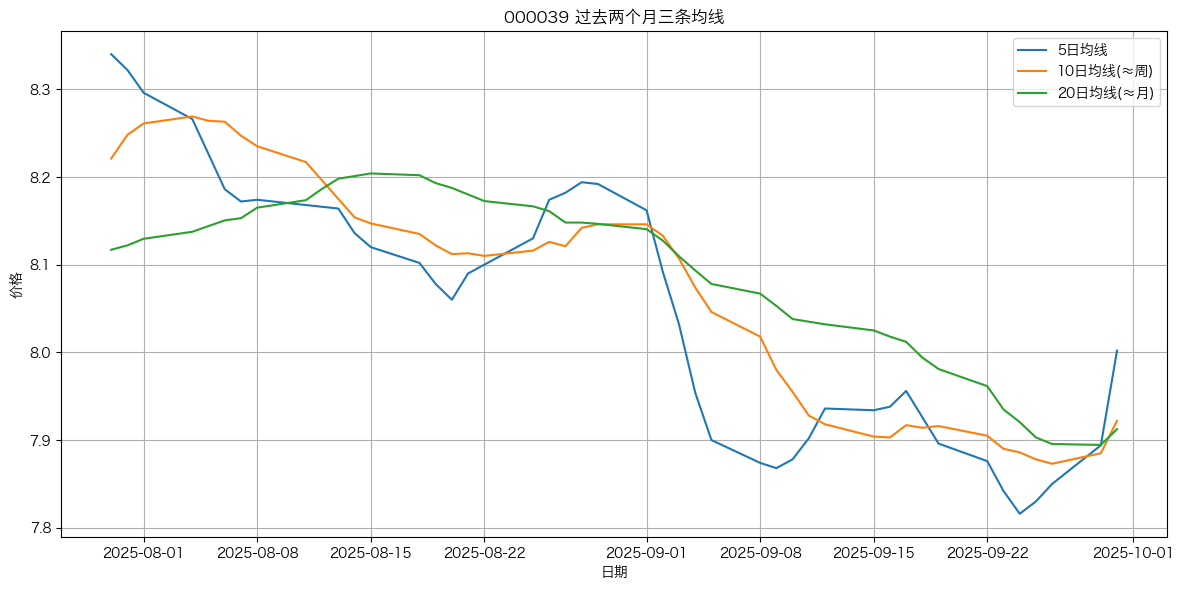

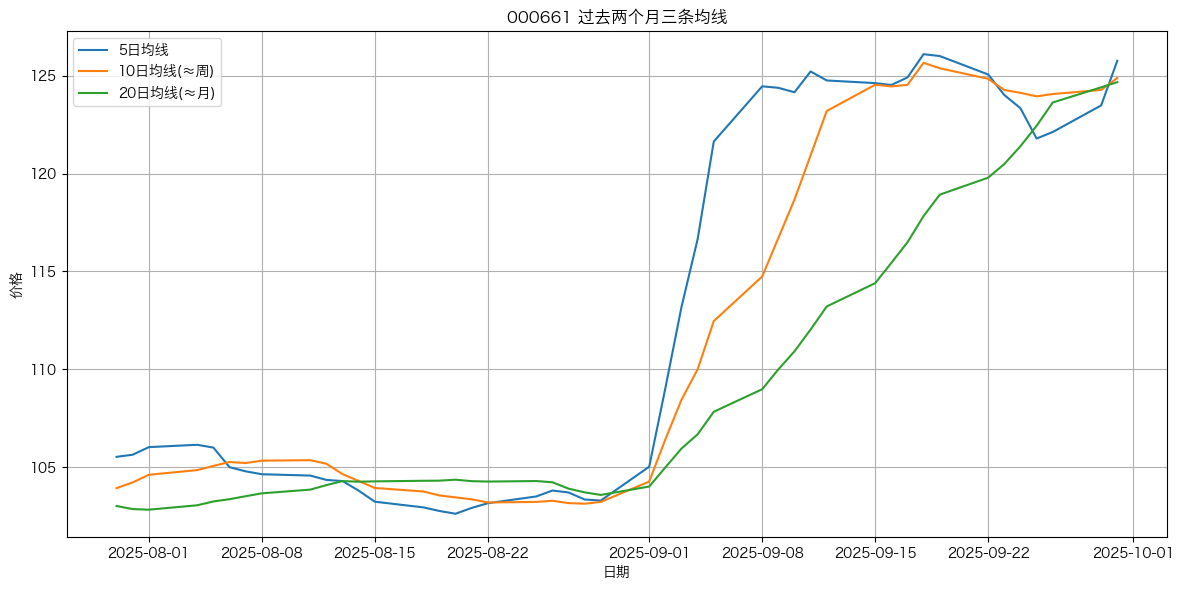

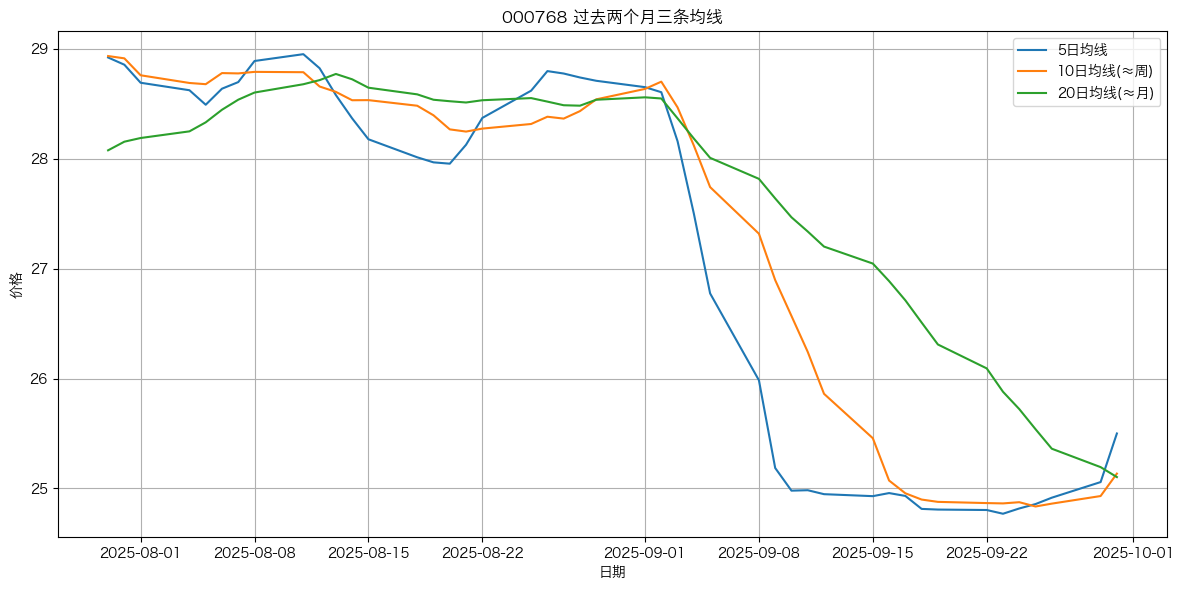

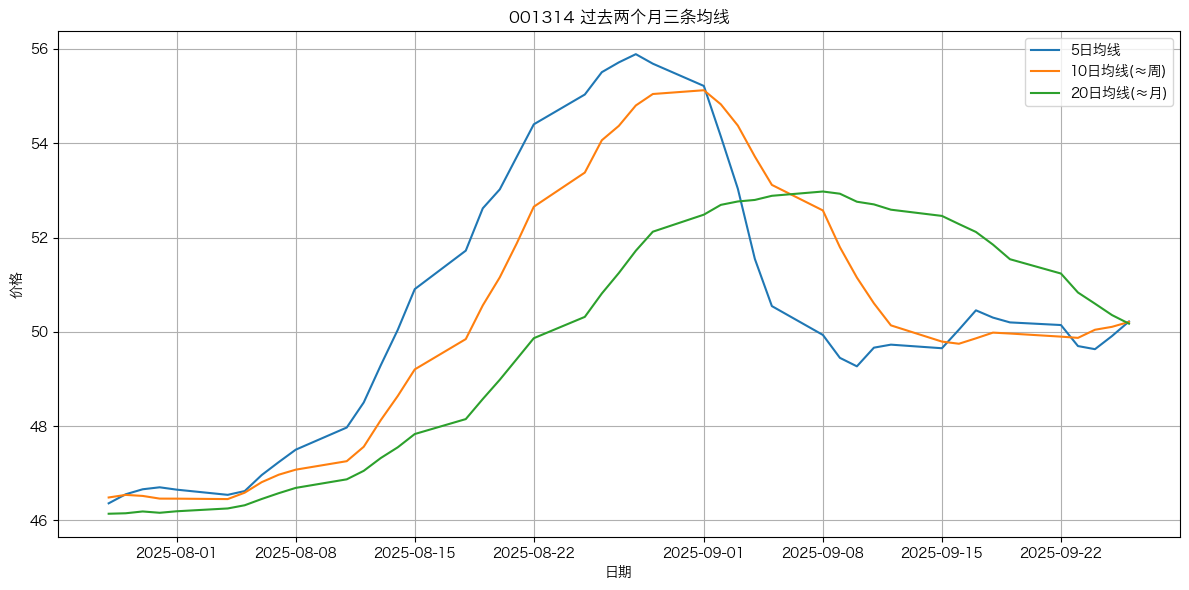

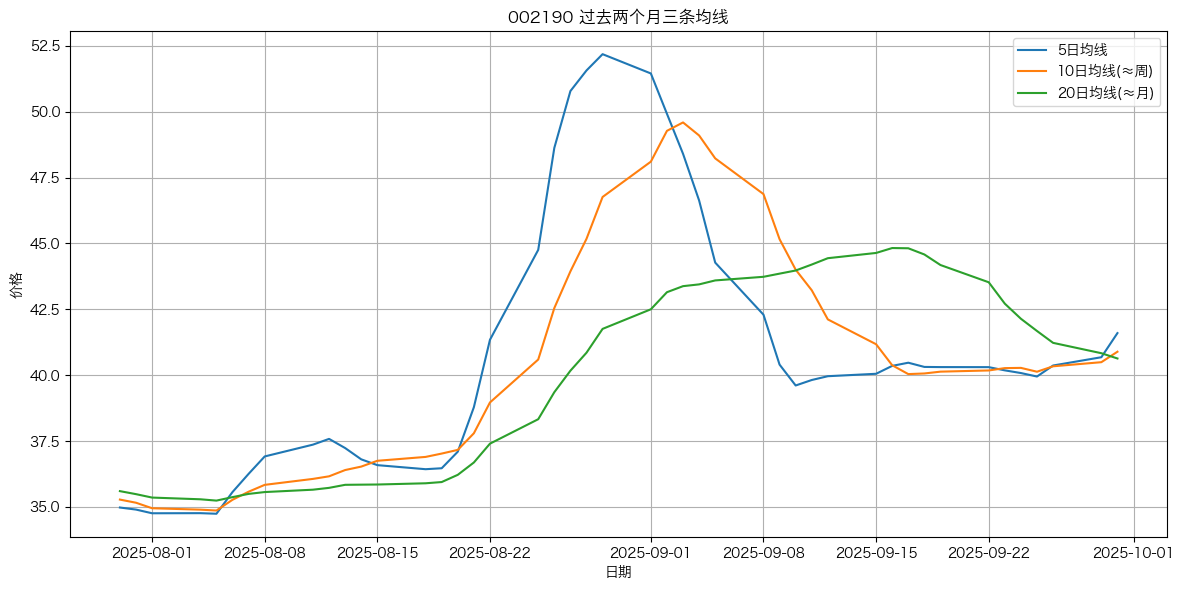

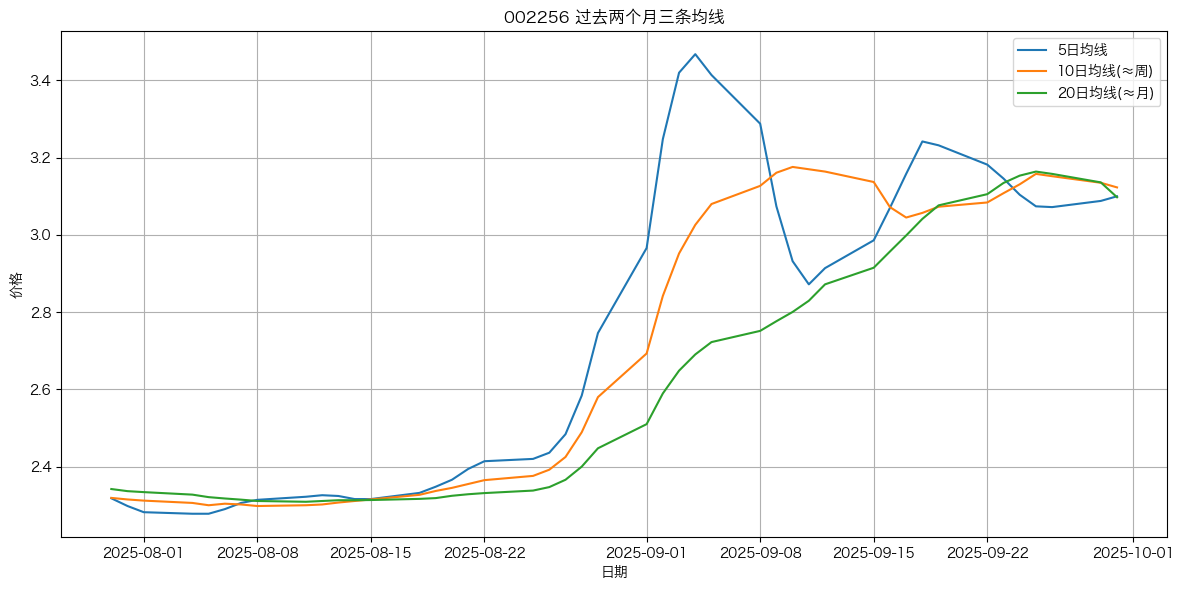

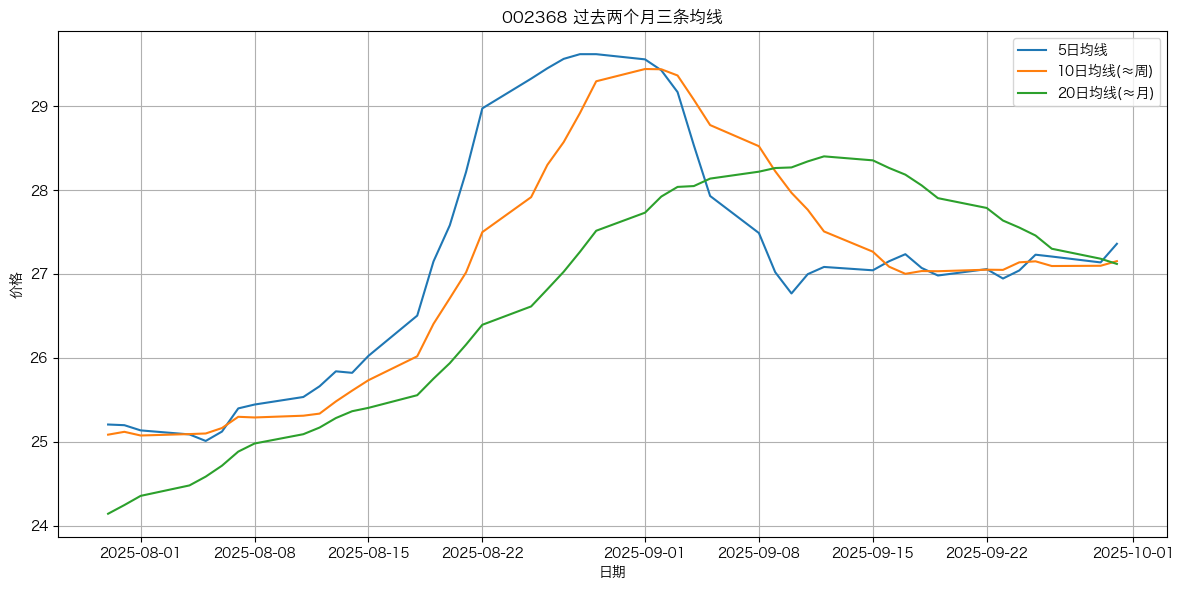

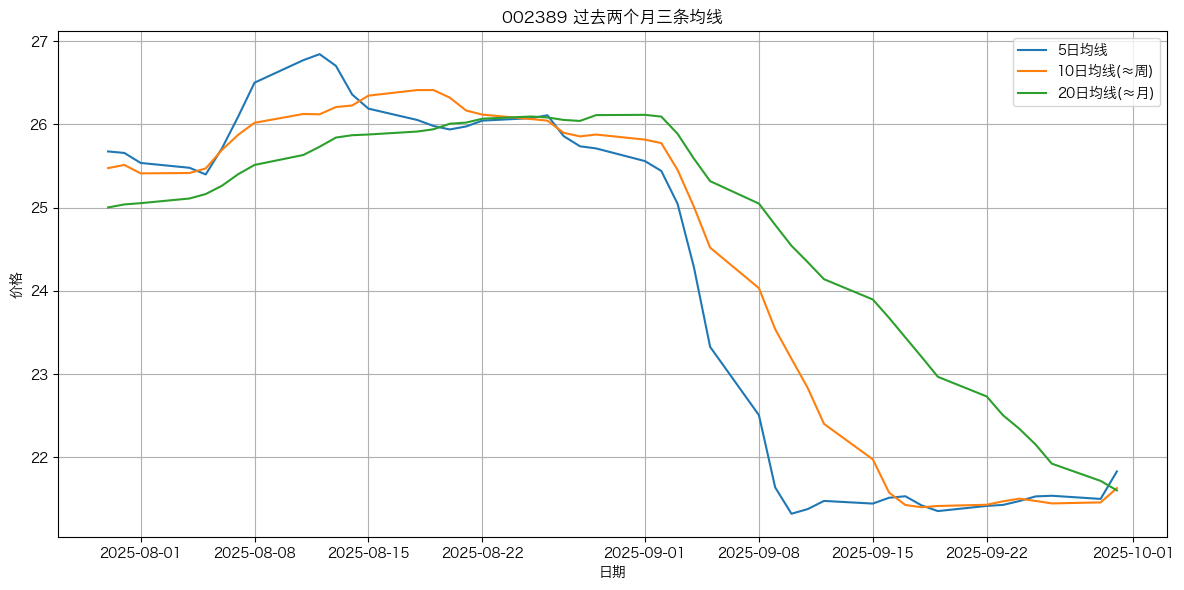

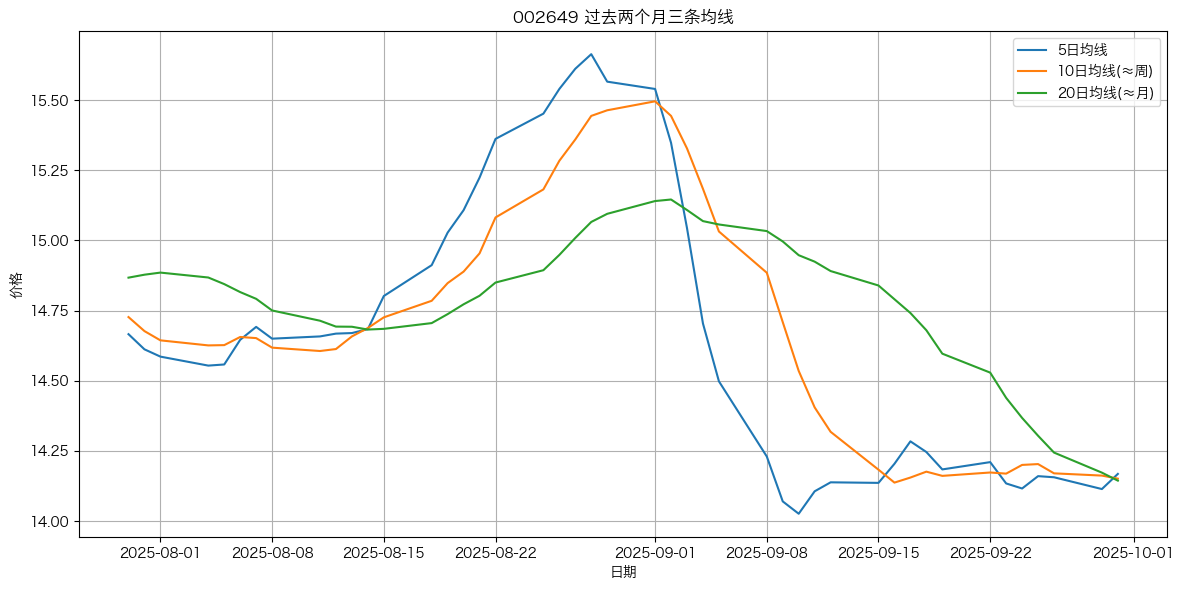

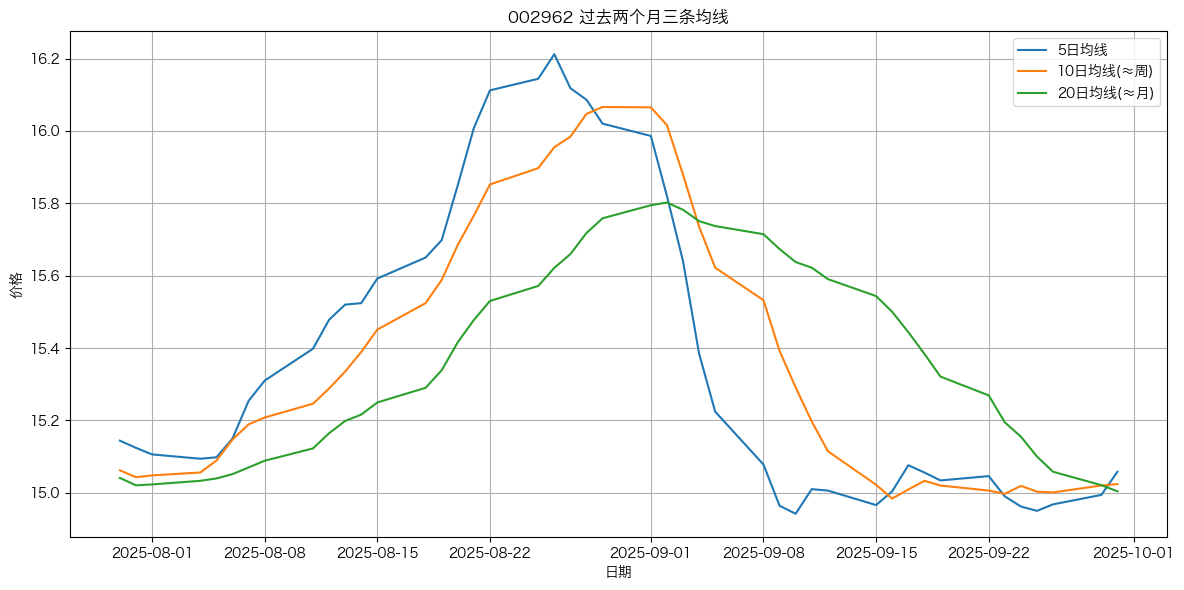

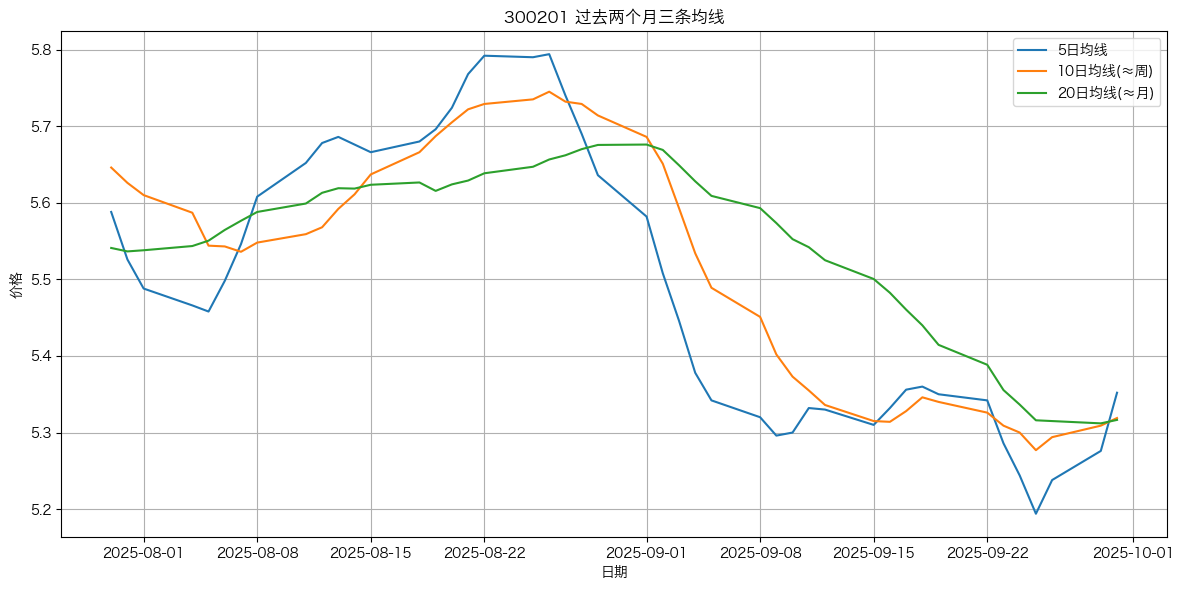

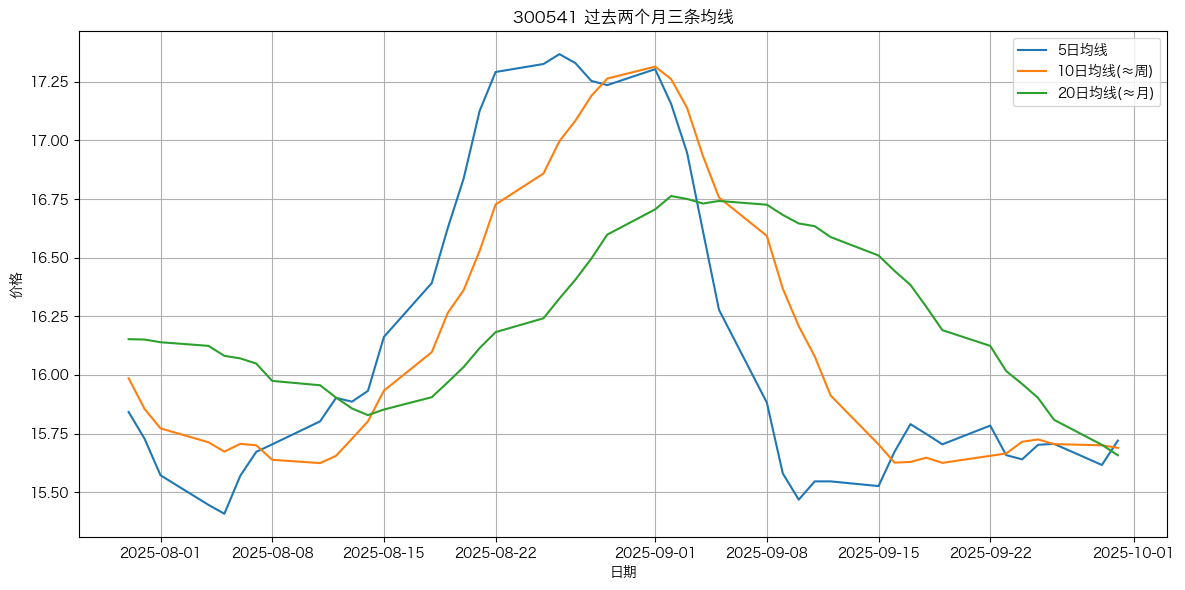

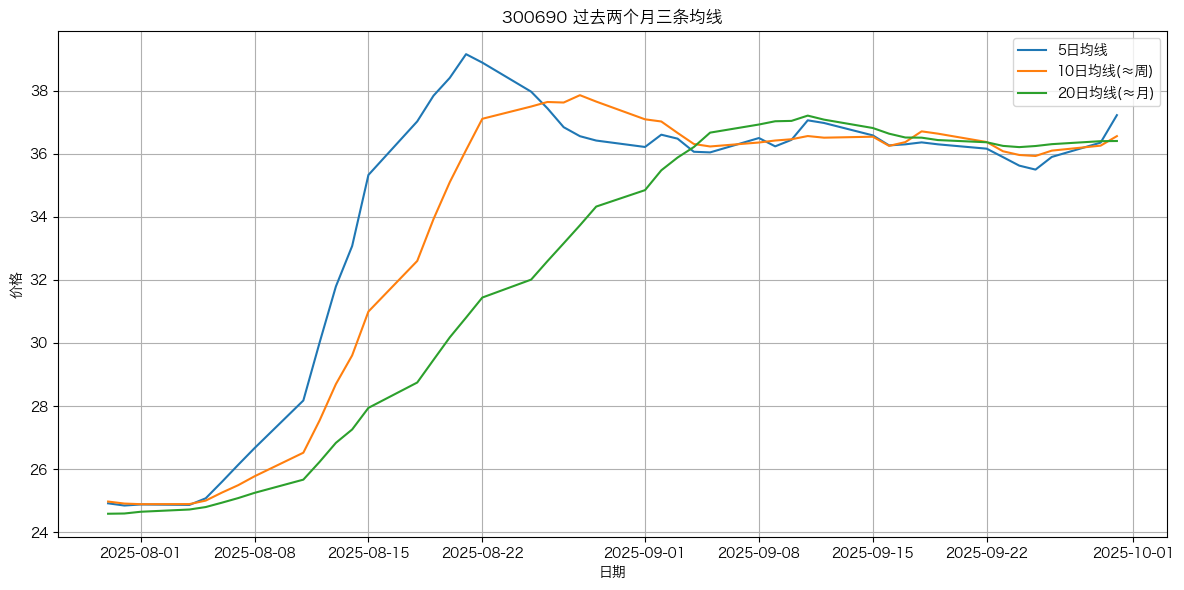

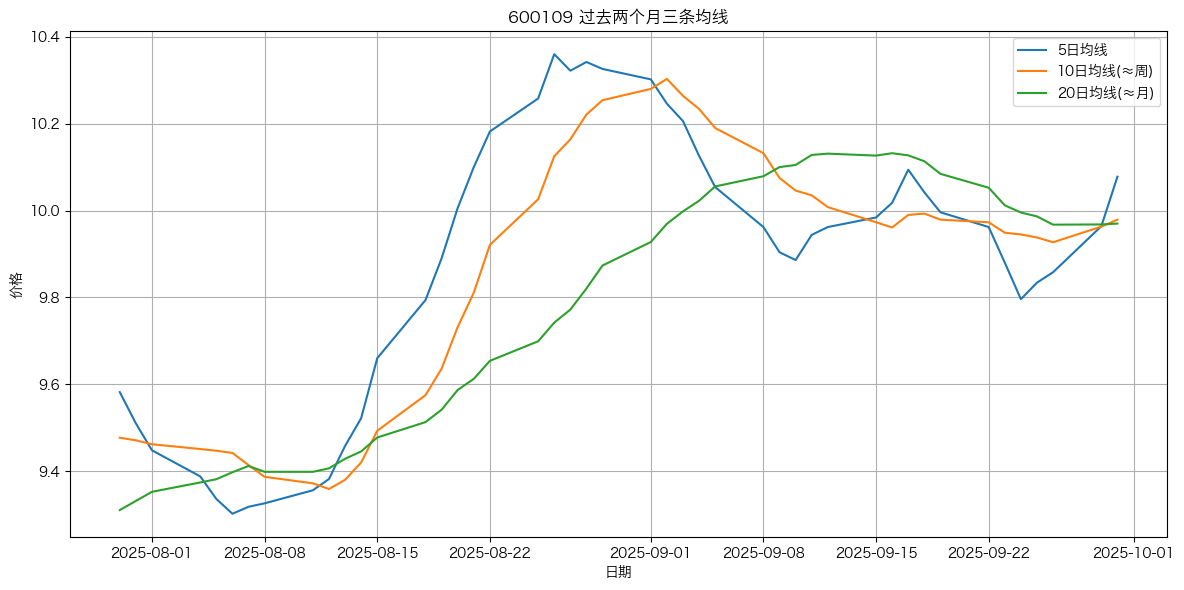

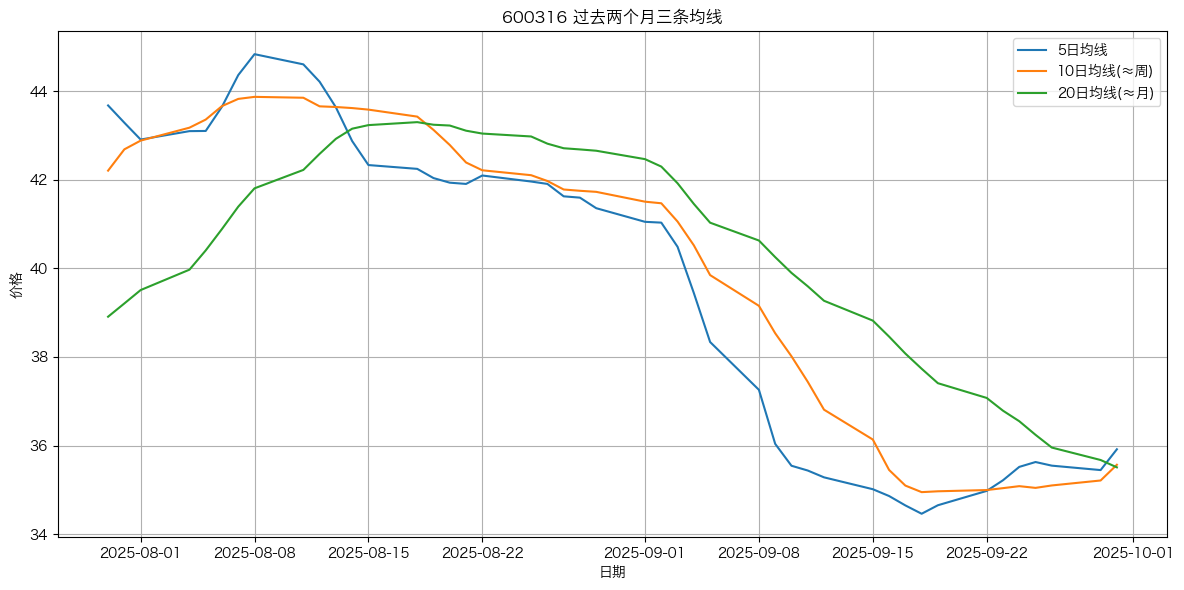

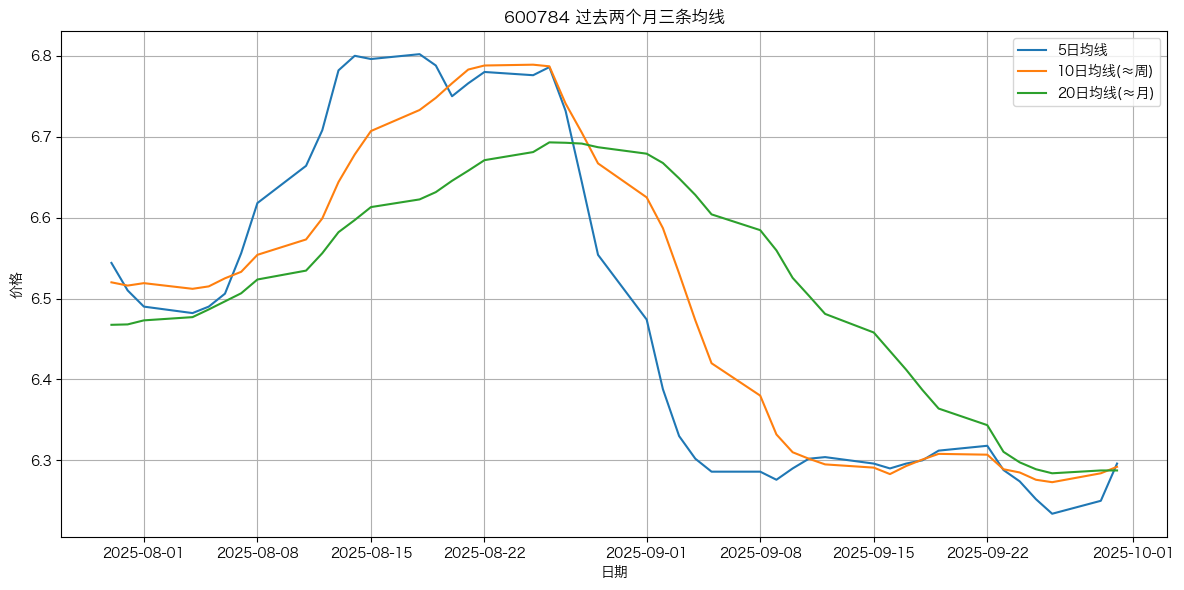

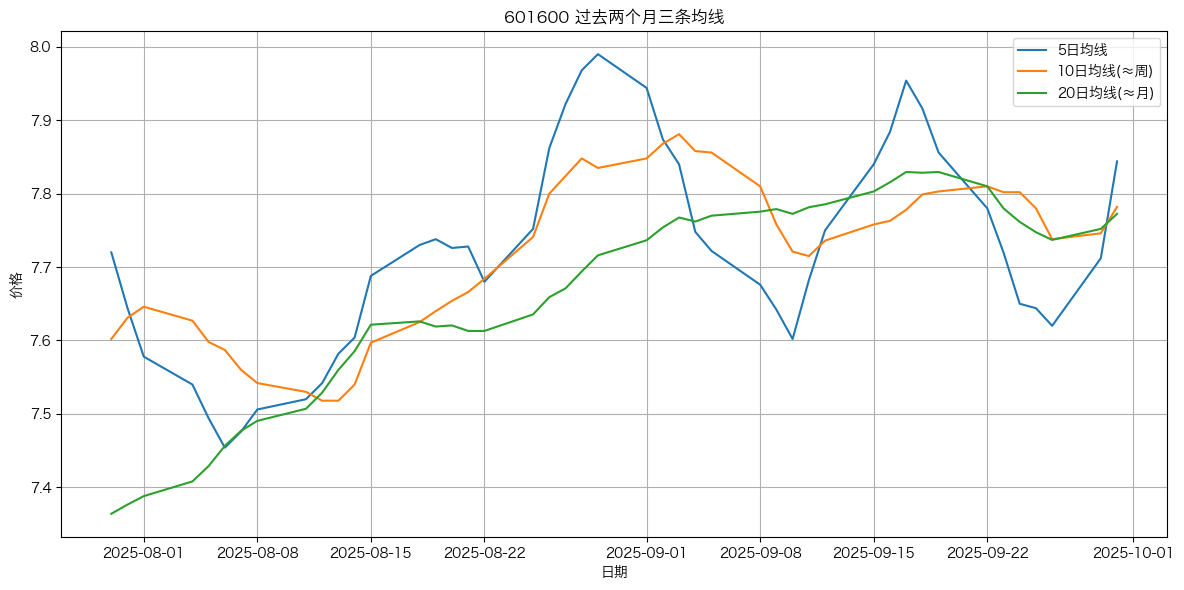

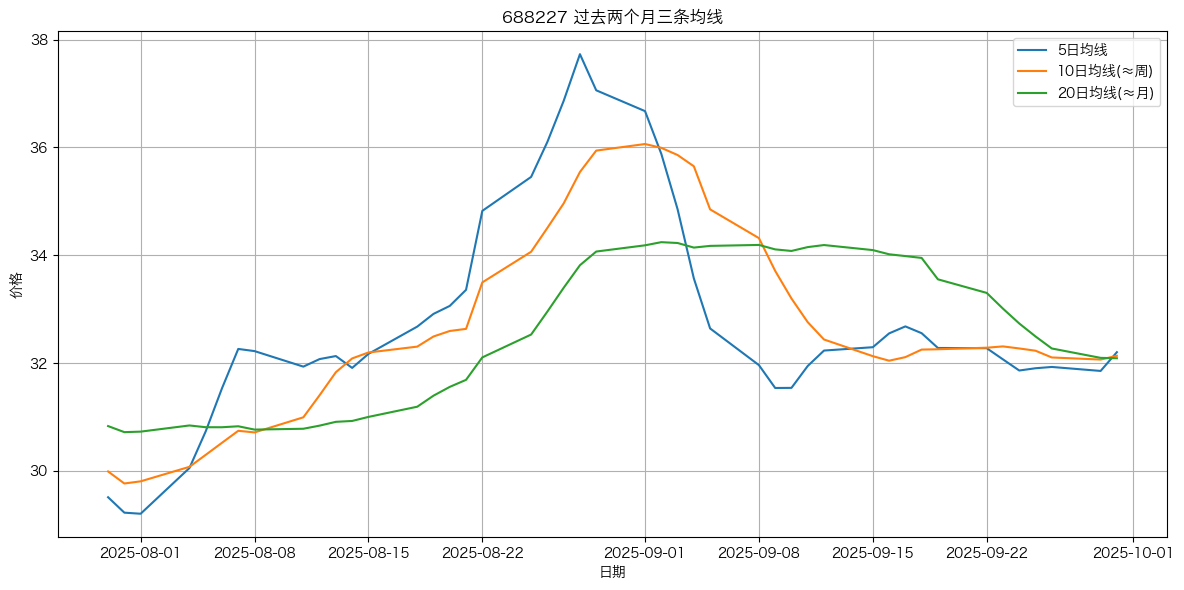

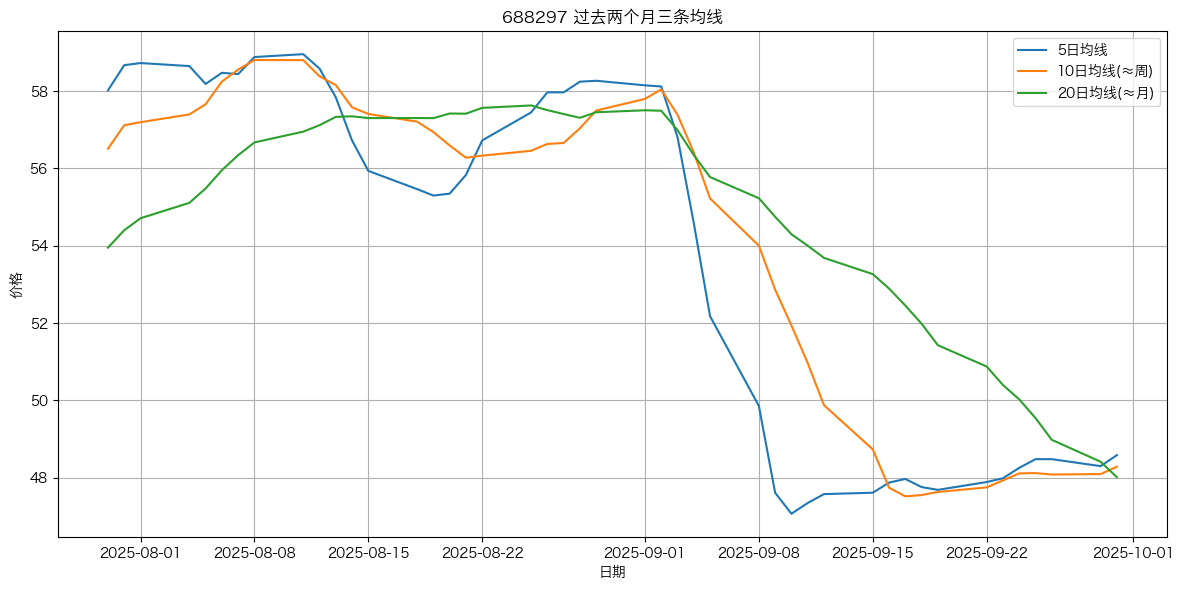

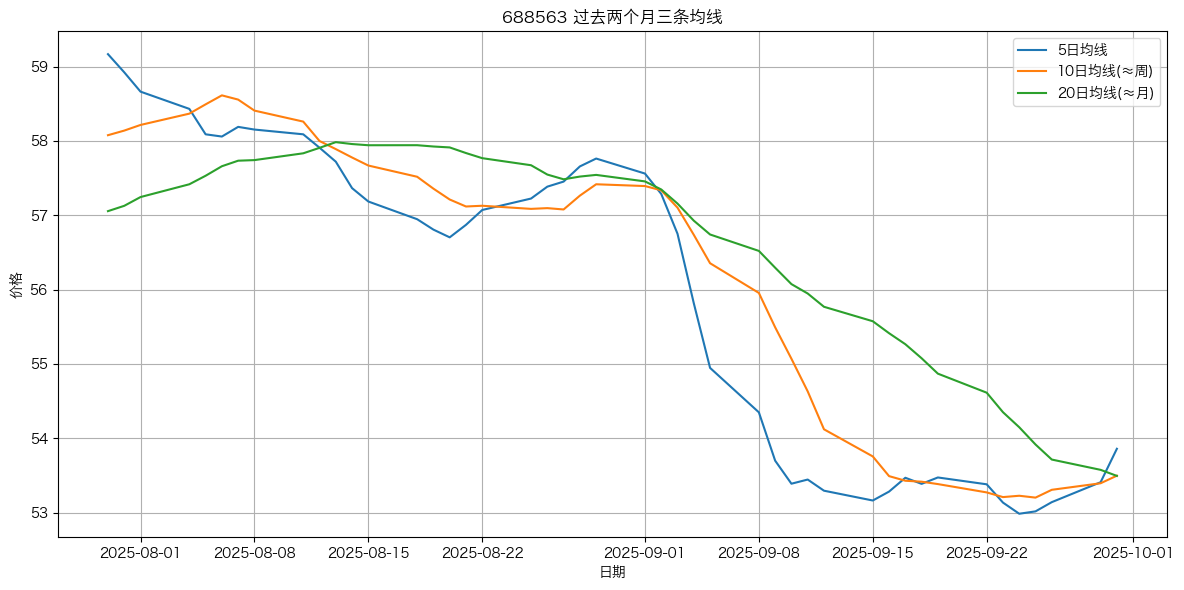

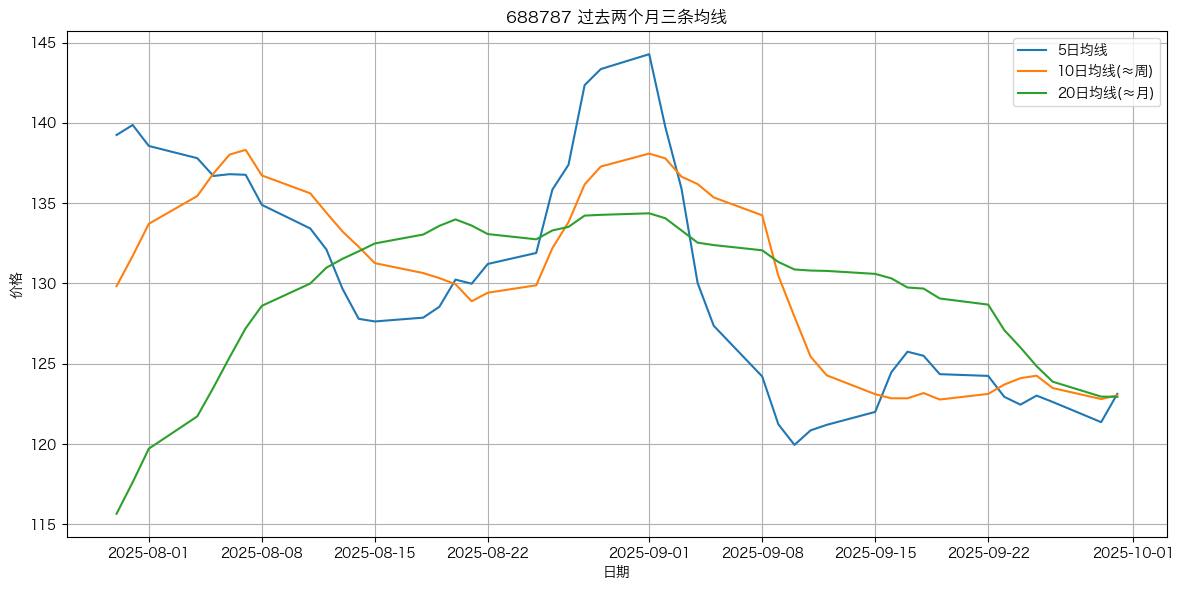

In [42]:
for i in symbols:
    plot_three_ma(i)  

In [47]:
_EM_SESSION = make_session_em(disable_system_proxy=True)


In [36]:
import requests, random, time
from urllib3.util.retry import Retry
from requests.adapters import HTTPAdapter

EM_K_HOSTS = [
    "https://push2his.eastmoney.com/api/qt/stock/kline/get",
    "https://push2.eastmoney.com/api/qt/stock/kline/get",
    "https://91.push2his.eastmoney.com/api/qt/stock/kline/get",
    "https://18.push2his.eastmoney.com/api/qt/stock/kline/get",
    "https://11.push2his.eastmoney.com/api/qt/stock/kline/get",
    "https://33.push2his.eastmoney.com/api/qt/stock/kline/get",
]

def make_session_em(disable_system_proxy: bool = False):
    s = requests.Session()
    retry = Retry(
        total=6, connect=6, read=6,
        backoff_factor=0.8,
        status_forcelist=[429, 500, 502, 503, 504],
        allowed_methods=frozenset(["GET"]),
        respect_retry_after_header=True,
        raise_on_status=False,
    )
    # 单连接池足够；配合 Connection: close 避免长连接积压
    s.mount("https://", HTTPAdapter(max_retries=retry, pool_connections=8, pool_maxsize=8))
    s.headers.update({
        "User-Agent": "Mozilla/5.0",
        "Referer": "https://quote.eastmoney.com/",
        "Accept": "application/json, text/plain, */*",
        "Connection": "close",
    })
    if disable_system_proxy:
        s.trust_env = False
    return s

_EM_SESSION = make_session_em()

def fetch_hist_em_direct(symbol: str, start_ymd: str, end_ymd: str, adjust: str = "", session=None) -> pd.DataFrame:
    session = session or _EM_SESSION
    fqt = {"": 0, "qfq": 1, "hfq": 2}.get(adjust or "", 0)
    secid = ("1." if symbol.startswith("6") else "0.") + symbol
    params = {
        "secid": secid, "klt": "101", "fqt": str(fqt),
        "beg": start_ymd, "end": end_ymd,
        "fields1": "f1,f2,f3,f4,f5,f6",
        "fields2": "f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61",
    }
    last_err = None
    for base in random.sample(EM_K_HOSTS, k=len(EM_K_HOSTS)):
        try:
            r = session.get(base, params=params, timeout=(10, 40))
            r.raise_for_status()
            j = r.json()
            kl = (j or {}).get("data", {}).get("klines", []) or []
            if not kl:
                raise RuntimeError("empty klines")
            rows = []
            for line in kl:
                p = line.split(",")  # date,open,close,high,low,volume,amount,...
                if len(p) < 7: 
                    continue
                rows.append({
                    "date": pd.to_datetime(p[0]),
                    "open": float(p[1]), "close": float(p[2]),
                    "high": float(p[3]), "low": float(p[4]),
                    "volume": float(p[5]), "amount": float(p[6]),
                })
            return (pd.DataFrame(rows)
                      .dropna()
                      .sort_values("date")
                      .set_index("date"))
        except Exception as e:
            last_err = e
            time.sleep(random.uniform(0.2, 0.6))  # 换节点前小抖动
            continue
    raise RuntimeError(f"EM direct kline 失败: {repr(last_err)}")


In [37]:
def batch_download_all(
    start_raw: str, end_raw: str, adjust: str = ADJUST,
    start_at: int = 1, resume_from_symbol: str | None = None,
    per_item_sleep: tuple[float,float] = (0.6, 1.2),
    cooldown_every: int = 50,
    cooldown_seconds: tuple[float,float] | float = (1000, 3700),
    second_pass: bool = True,
    second_pass_cooldown: tuple[float,float] = (200, 260),
    # —— 稳态参数 —— 
    rate_per_min: int = 15,
    session_refresh_every: int = 100,
    circuit_fail_window: int = 5,
    circuit_fail_threshold: int = 3,
    circuit_sleep_range: tuple[float,float] = (1200, 1800),
    # —— 新参数：每只代码的常规重试次数（不含最后冷却兜底）——
    retry_per_symbol: int = 3,
):
    """
    分批下载所有 A 股历史到 CSV，带限速/冷却/会话轮换/断路器/失败二扫。
    """
    import random, time, os

    class RateLimiter:
        def __init__(self, rpm: int):
            self.interval = 60.0 / max(1, rpm)
            self.last = 0.0
        def sleep(self):
            now = time.time()
            wait = self.interval - (now - self.last)
            if wait > 0:
                time.sleep(wait)
            self.last = time.time()

    def _sleep_range(rng):
        if isinstance(rng, (tuple, list)) and len(rng) == 2:
            import random as _r
            time.sleep(_r.uniform(rng[0], rng[1]))
        elif isinstance(rng, (int, float)) and rng > 0:
            time.sleep(float(rng))

    limiter = RateLimiter(rate_per_min)

    start = normalize_ymd(start_raw)
    end   = normalize_ymd(end_raw)
    ensure_dir(DATA_DIR)

    codes = load_a_share_codes()
    total = len(codes)

    if resume_from_symbol:
        import numpy as np
        mask = (codes["code"].astype(str).str.strip() == str(resume_from_symbol).strip())
        idxs = np.where(mask.values)[0]
        if len(idxs):
            start_at = int(idxs[0]) + 2
        else:
            print(f"提示：代码 {resume_from_symbol} 不在列表中，改用 start_at={start_at}")

    start_at = max(1, min(start_at, total))
    iter_df = codes.iloc[start_at-1:]

    ok = fail = hits = 0
    fail_queue: list[tuple[str,str]] = []
    recent_fails: list[bool] = []

    print(f"计划下载：{total} 只；从第 {start_at}/{total} 开始；区间 {start}~{end}；口径：{adjust or 'none'}")

    global _EM_SESSION

    # ---------- 第一轮 ----------
    for j, row in enumerate(iter_df.itertuples(index=False), start=start_at):
        sym, name = row.code, row.name
        out = csv_path(sym)

        if os.path.exists(out):
            print(f"[{j}/{total}] 跳过 {sym} {name}（已存在）")
            continue

        # 断路器
        if len(recent_fails) >= circuit_fail_window and sum(recent_fails[-circuit_fail_window:]) >= circuit_fail_threshold:
            import random as _r
            cool = _r.uniform(*circuit_sleep_range)
            print(f"⛔ 连续失败触发断路器：休眠 {cool:.1f}s 并重建会话 …")
            time.sleep(cool)
            _EM_SESSION = make_session_em()
            recent_fails.clear()

        limiter.sleep()
        _sleep_range(per_item_sleep)

        hits += 1
        if session_refresh_every > 0 and (hits % session_refresh_every == 0):
            print("♻️ 轮换 EM 会话 …")
            _EM_SESSION = make_session_em()

        last_err = None
        success = False

        # 常规重试（指数退避）
        for t in range(retry_per_symbol):
            try:
                df = fetch_hist(sym, start, end, adjust)
                df.to_csv(out, index=True)
                ok += 1
                print(f"[{j}/{total}] 保存 {sym} {name}：{len(df)} 条")
                success = True
                break
            except Exception as e:
                last_err = e
                msg = str(e)
                if ("Remote end closed" in msg) or ("Connection" in msg) or ("Timeout" in msg):
                    backoff = min(6 * (t + 1), 24)
                    print(f"[{j}/{total}] {sym} 出错（{e}），{backoff}s 后重试({t+1}/{retry_per_symbol})…")
                    time.sleep(backoff)
                else:
                    time.sleep(0.6)

        if not success:
            print(f"[{j}/{total}] {sym} 常规重试已用尽，冷却 30s 后最后尝试一次…")
            time.sleep(30)
            try:
                df = fetch_hist(sym, start, end, adjust)
                df.to_csv(out, index=True)
                ok += 1
                print(f"[{j}/{total}] 保存 {sym} {name}：{len(df)} 条（冷却重试成功）")
                success = True
            except Exception as e2:
                fail += 1
                fail_queue.append((sym, name))
                print(f"[{j}/{total}] 失败 {sym} {name}：{repr(last_err)}；冷却重试仍失败：{repr(e2)}")

        recent_fails.append(not success)
        if len(recent_fails) > circuit_fail_window:
            recent_fails = recent_fails[-circuit_fail_window:]

        if success and cooldown_every > 0 and (hits % cooldown_every == 0):
            _sleep_range(cooldown_seconds)
            print(f"📦 已抓取 {hits} 只，完成强制冷却。")

    print(f"\n第一轮完成：成功 {ok}，失败 {fail}，目录：{os.path.abspath(DATA_DIR)}")

    # ---------- 第二轮 ----------
    if second_pass and fail_queue:
        print(f"\n开始二次扫描（失败 {len(fail_queue)} 只，慢速冷却重试）…")
        still_fail = []
        for idx, (sym, name) in enumerate(fail_queue, 1):
            print(f"[二次 {idx}/{len(fail_queue)}] 准备重试 {sym} {name}")
            _sleep_range(second_pass_cooldown)
            _EM_SESSION = make_session_em()
            try:
                df = fetch_hist(sym, start, end, adjust)
                df.to_csv(csv_path(sym), index=True)
                ok += 1; fail -= 1
                print(f"[二次 {idx}/{len(fail_queue)}] 成功 {sym}：{len(df)} 条")
            except Exception as e3:
                still_fail.append((sym, name, repr(e3)))
                print(f"[二次 {idx}/{len(fail_queue)}] 仍失败 {sym}：{repr(e3)}")

        if still_fail:
            print("\n以下代码在二次扫描后仍失败（建议稍后单独重试或换网络/代理）：")
            for sym, name, err in still_fail:
                print(f" - {sym} {name} -> {err}")

    print(f"\n最终统计：成功 {ok}，失败 {fail}，目录：{os.path.abspath(DATA_DIR)}")



In [38]:
batch_download_all(START_DATE_RAW, END_DATE_RAW, ADJUST, start_at=1898, retry_per_symbol=3)

计划下载：5436 只；从第 1898/5436 开始；区间 20250630~20250930；口径：none
[1898/5436] 保存 300447 全信股份：67 条
[1899/5436] 保存 300448 浩云科技：67 条
[1900/5436] 保存 300449 汉邦高科：67 条
[1901/5436] 保存 300450 先导智能：67 条
[1902/5436] 保存 300451 创业慧康：67 条
[1903/5436] 保存 300452 山河药辅：67 条
[1904/5436] 保存 300453 三鑫医疗：67 条
[1905/5436] 保存 300454 深信服：67 条
[1906/5436] 保存 300455 航天智装：67 条
[1907/5436] 保存 300456 赛微电子：67 条
[1908/5436] 保存 300457 赢合科技：67 条
[1909/5436] 保存 300458 全志科技：67 条
[1910/5436] 保存 300459 汤姆猫：67 条
[1911/5436] 保存 300460 惠伦晶体：67 条
[1912/5436] 保存 300461 田中精机：67 条
[1913/5436] 保存 300462 ST华铭：66 条
[1914/5436] 保存 300463 迈克生物：67 条
[1915/5436] 保存 300464 星徽股份：67 条
[1916/5436] 保存 300465 高伟达：67 条
[1917/5436] 保存 300466 赛摩智能：67 条
[1918/5436] 保存 300467 迅游科技：67 条
[1919/5436] 保存 300468 四方精创：67 条
[1920/5436] 保存 300469 信息发展：67 条
[1921/5436] 保存 300470 中密控股：67 条
[1922/5436] 保存 300471 厚普股份：67 条
[1923/5436] 保存 300472 *ST新元：67 条
[1924/5436] 保存 300473 德尔股份：67 条
[1925/5436] 保存 300474 景嘉微：67 条
[1926/5436] 保存 300475 香农芯创：67 条
[1927/5436] 保存 300

In [35]:
import inspect
src = inspect.getsource(batch_download_all)
print("是否仍含 RETRY_PER_SYMBOL? ->", "RETRY_PER_SYMBOL" in src)
print(src[:600])  # 看看签名和重试循环是不是 retry_per_symbol

是否仍含 RETRY_PER_SYMBOL? -> True
def batch_download_all(
    start_raw: str, end_raw: str, adjust: str = ADJUST,
    start_at: int = 1, resume_from_symbol: str | None = None,
    per_item_sleep: tuple[float,float] = (0.6, 1.2),  # 放慢一点
    cooldown_every: int = 50,                         # 每 50 只强制冷却
    cooldown_seconds: tuple[float,float] | float = (1000, 3700),
    second_pass: bool = True,                         # 失败队列二次扫描
    second_pass_cooldown: tuple[float,float] = (200, 260),
    # —— 新增稳态参数 —— 
    rate_per_min: int = 15,           # 速率：每分钟最多请求数（令牌桶）
    session_refresh_every: int = 100, # 每抓 100 只重建一次 EM 会话
    c


In [33]:
_EM_SESSION = make_session_em(disable_system_proxy=True)


In [23]:
symbols = find_bull_cross_symbols(lookback=1)
print("触发信号的股票：", symbols)

触发信号的股票： ['000039', '000661', '000768', '001314', '002190', '002256', '002368', '002389', '002649', '002962', '300201', '300690', '600109', '600316', '600784', '601600', '688227', '688297', '688563', '688787']


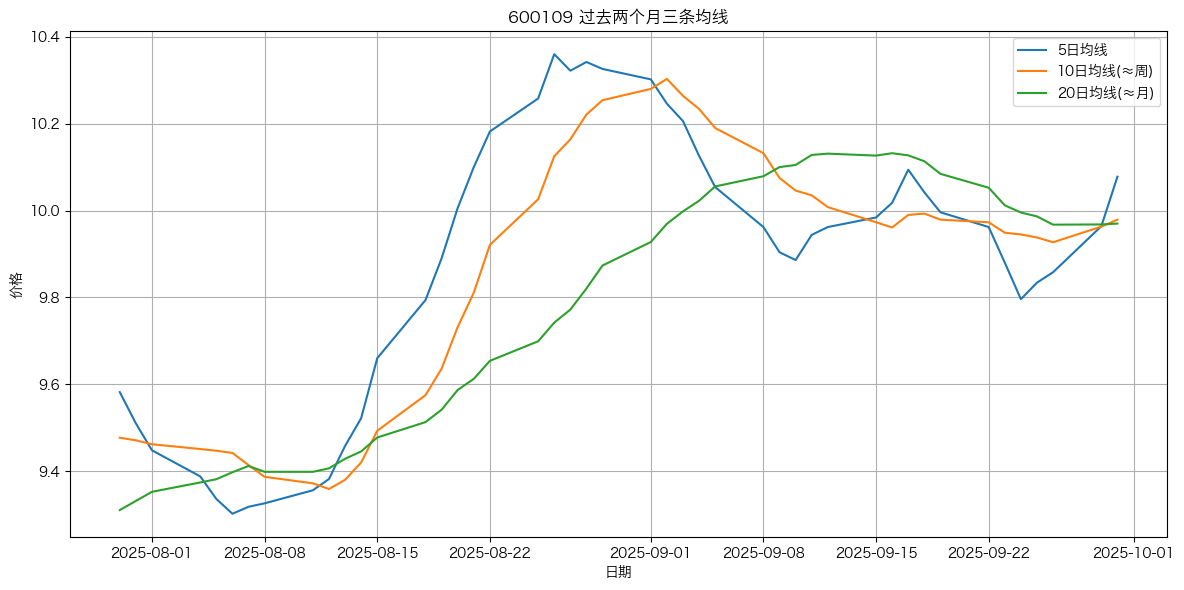

In [65]:
plot_three_ma("600109")  